# ANÁLISIS DE SENTIMIENTOS

## UTILIDADES

In [90]:
import sys

sys.path.append('../..')

In [91]:
from app.services.dataset_service import DatasetService

dataset_service = DatasetService()

In [92]:
import requests
import pandas as pd

def post(url: str):
    payload={}
    headers = {}
    response = requests.request("POST", url, headers=headers, data=payload)
    return response.json()

### Curvas de aprendizaje

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20, 4))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [94]:
from app.services.custom_analysis_service import classifiers, CustomAnalysisService


def learning_curves_examples(
    file_path: str,
    classifier_name: str,
    dataset_name: str
):
    cas = CustomAnalysisService()

    df_original = cas.prepare_dataset(
        file_path=file_path,
        target_column='sentiment',
        text_column='answer'
    )

    x_values = df_original.drop(['sentiment', 'answer'], axis=1)
    y_values = df_original['sentiment']
    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    estimator = classifiers[classifier_name]

    plot_learning_curve(
        estimator=estimator,
        title=f'Curvas de aprendizaje en dataset {dataset_name} ({classifier_name} - examples)',
        X=x_values,
        y=y_values,
        ylim=(0.4, 1.01),
        cv=cv,
        n_jobs=4
    )


## ANÁLISIS

In [95]:
custom_evaluation_url = 'http://localhost:8000/analysis/custom_evaluation'
metrics_custom_url = 'http://localhost:8000/analysis/metrics_custom'

In [96]:
metrics = [
    'accuracy',
    'sensitivity',
    'specificity',
    'auc',
    'kappa',
    'f1',
    'precision'
]

counts = ['tp', 'fp', 'tn', 'fn']

### Dataset original

#### Clasificación

In [97]:
url = f'{custom_evaluation_url}?file_path=cle_respuestas_form_1671774115.csv'
file_original = post(url)['file_path']

#### Métricas

In [98]:
url = f'{metrics_custom_url}?file_path={file_original}'
file_original = post(url)['file_path']
df_original = dataset_service.read_dataset(
    file_path=f'../../resources/metrics/{file_original}',
    encoding='utf-8',
    delimiter=','
)
df_original.head()


algorithm  accuracy  sensitivity  specificity     kappa        f1  \
0  nearest_neighbors  0.652174     0.705882     0.500000  0.185841  0.750000   
1         linear_svm  1.000000     1.000000     1.000000  1.000000  1.000000   
2            rbf_svm  0.739130     1.000000     0.000000  0.000000  0.850000   
3   gaussian_process  0.565217     0.705882     0.166667 -0.127451  0.705882   
4      decision_tree  1.000000     1.000000     1.000000  1.000000  1.000000   

   precision  tp  fp  tn  fn       auc  
0   0.800000  12   5   3   3  0.588235  
1   1.000000  17   0   6   0  1.000000  
2   0.739130  17   0   0   6  0.500000  
3   0.705882  12   5   1   5  0.490196  
4   1.000000  17   0   6   0  1.000000

<AxesSubplot: title={'center': 'Métricas en dataset original'}, xlabel='algorithm'>

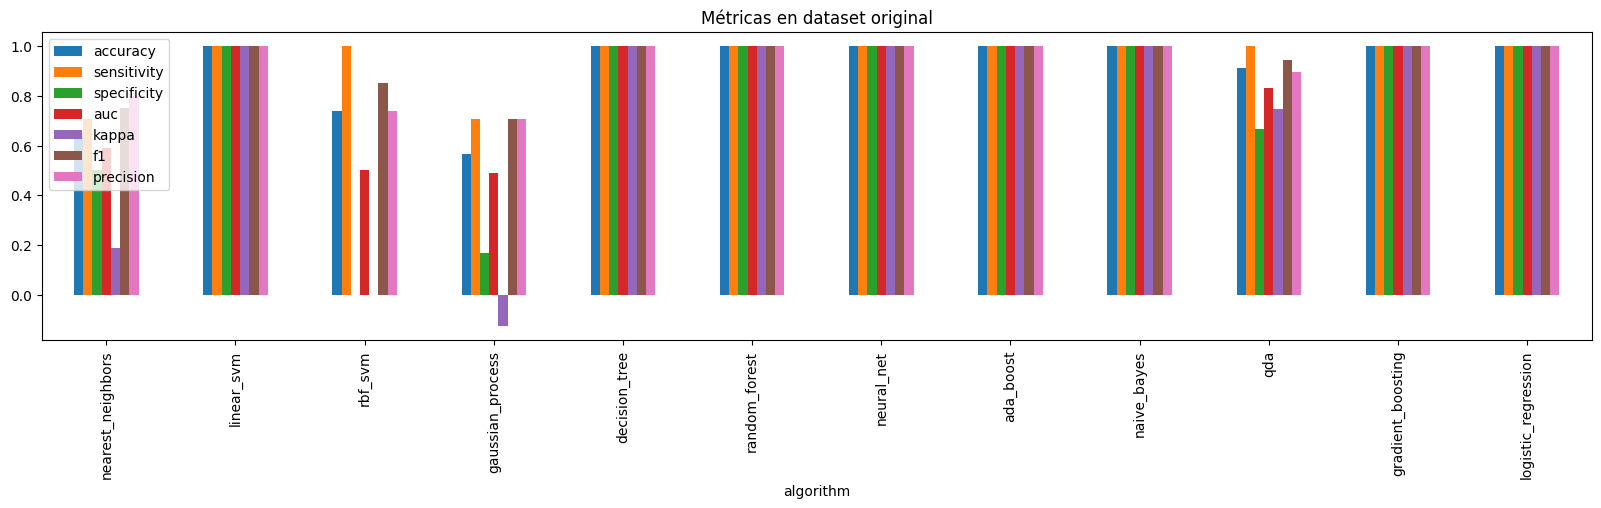

In [99]:
df_original[['algorithm'] + metrics].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Métricas en dataset original'
)

<AxesSubplot: title={'center': 'Conteos en dataset original'}, xlabel='algorithm'>

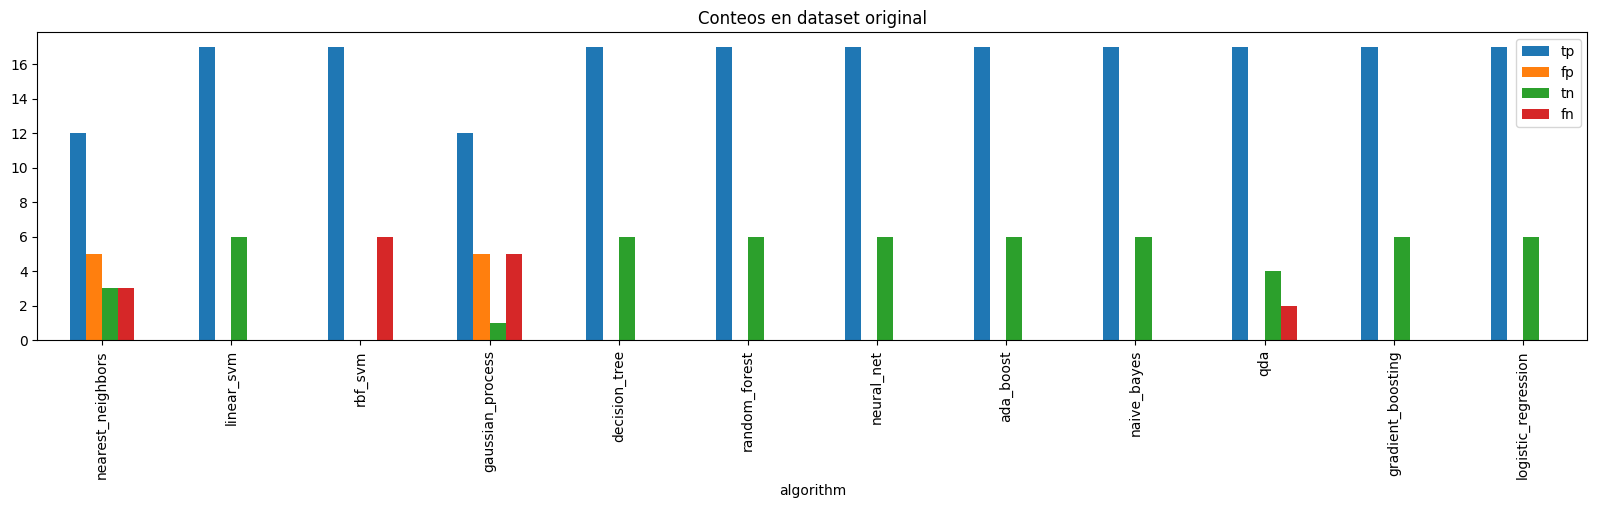

In [100]:
df_original[['algorithm'] + counts].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Conteos en dataset original'
)

#### Curvas de aprendizaje

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100

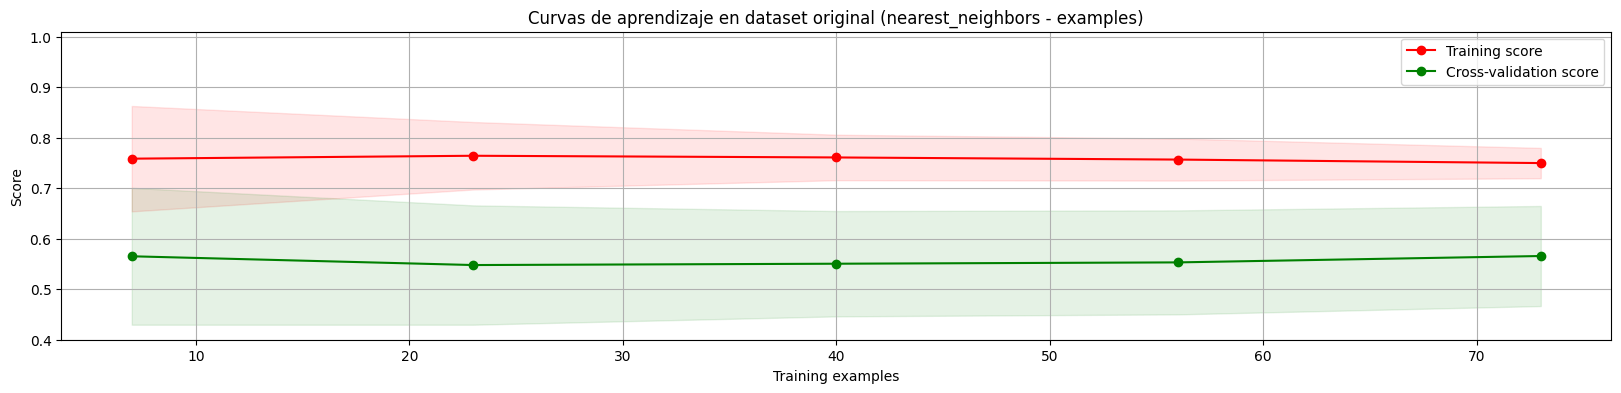

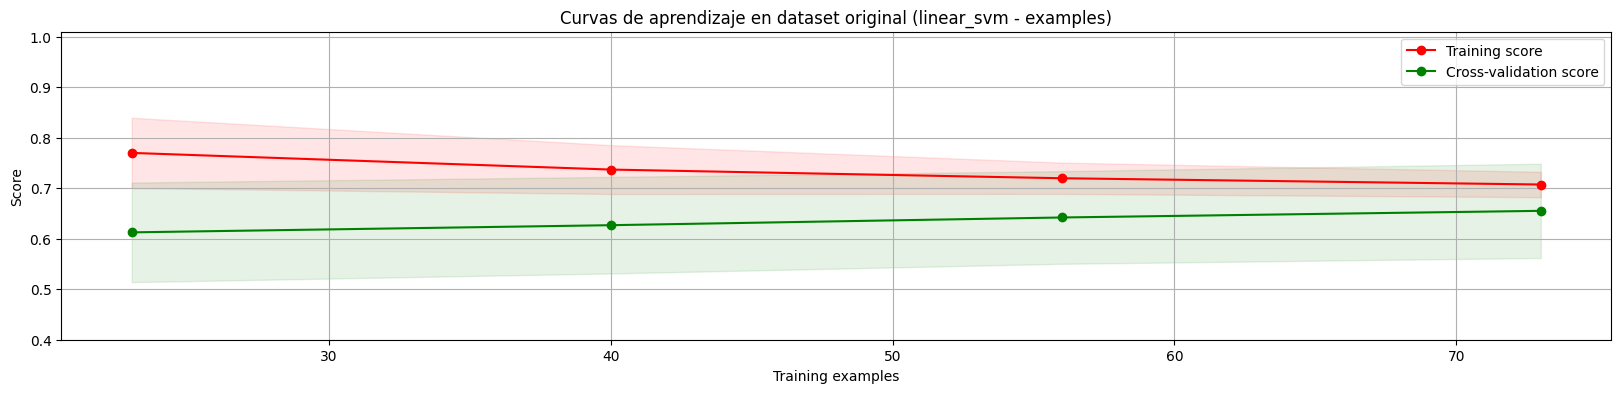

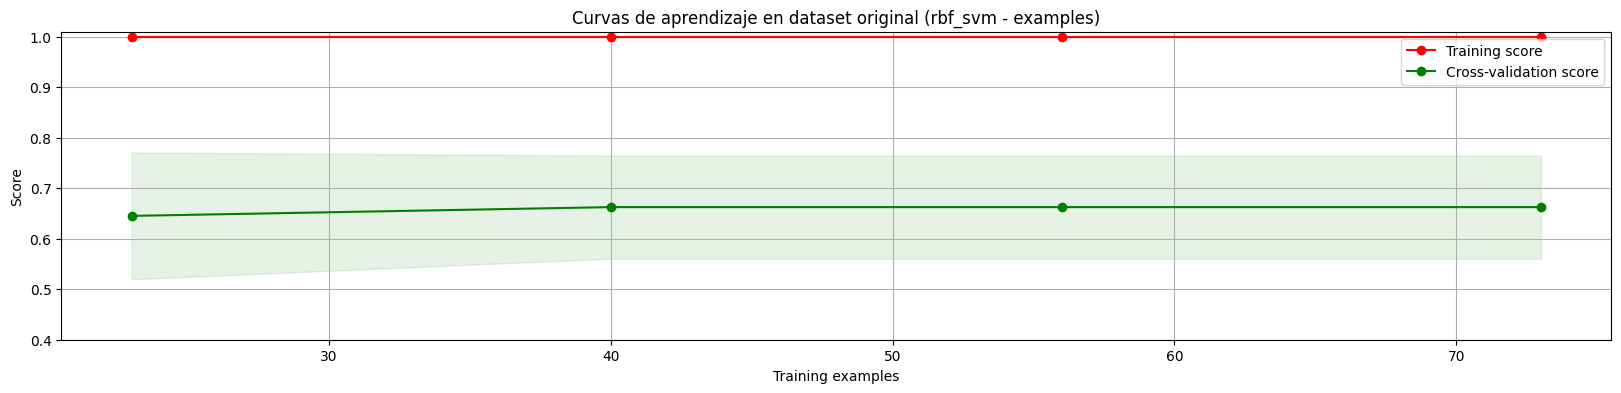

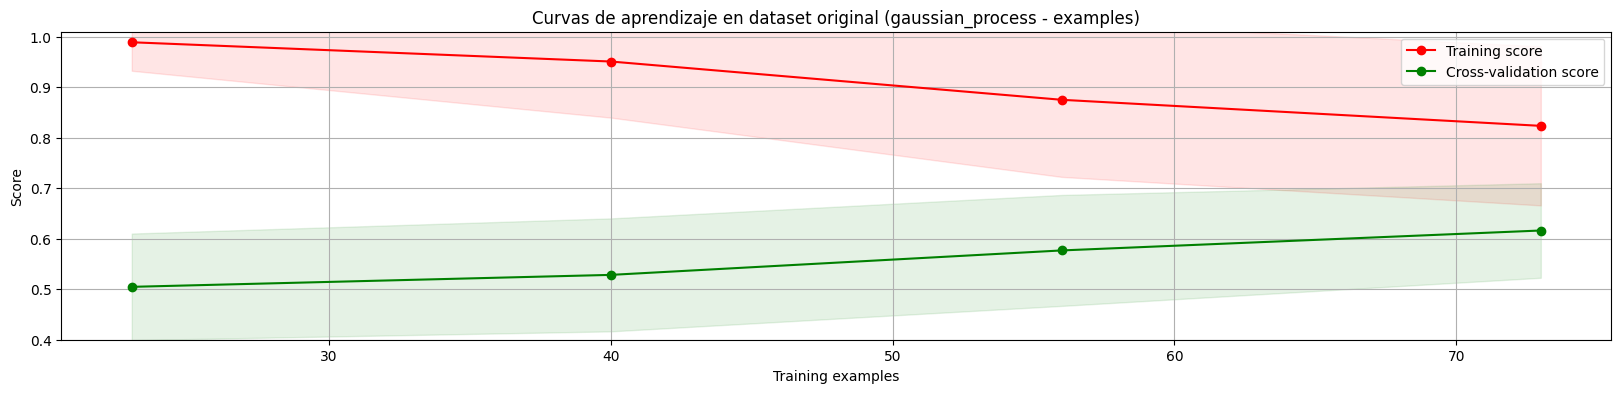

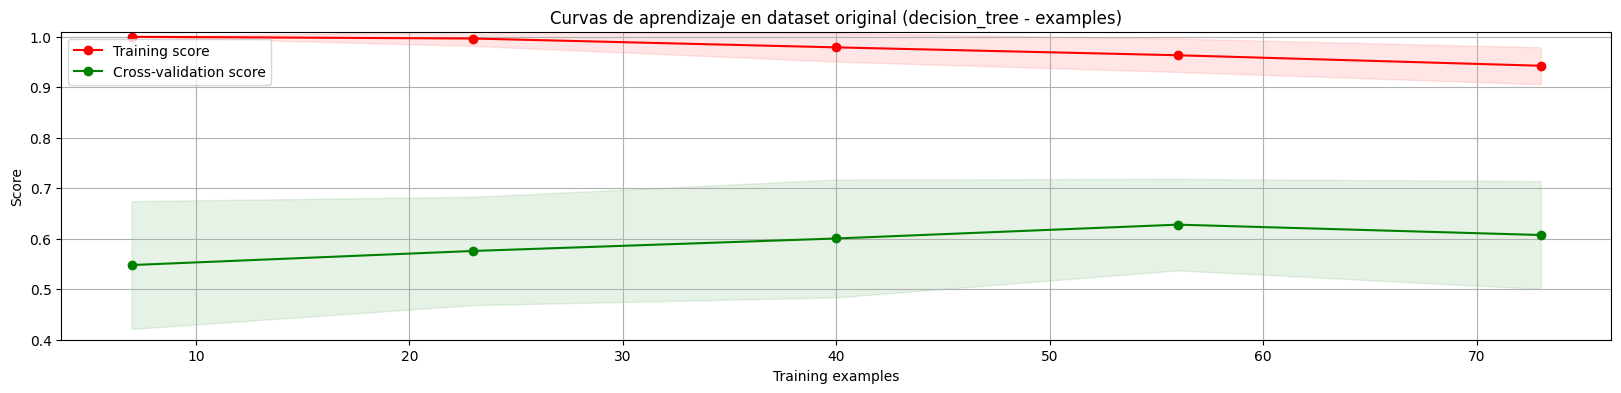

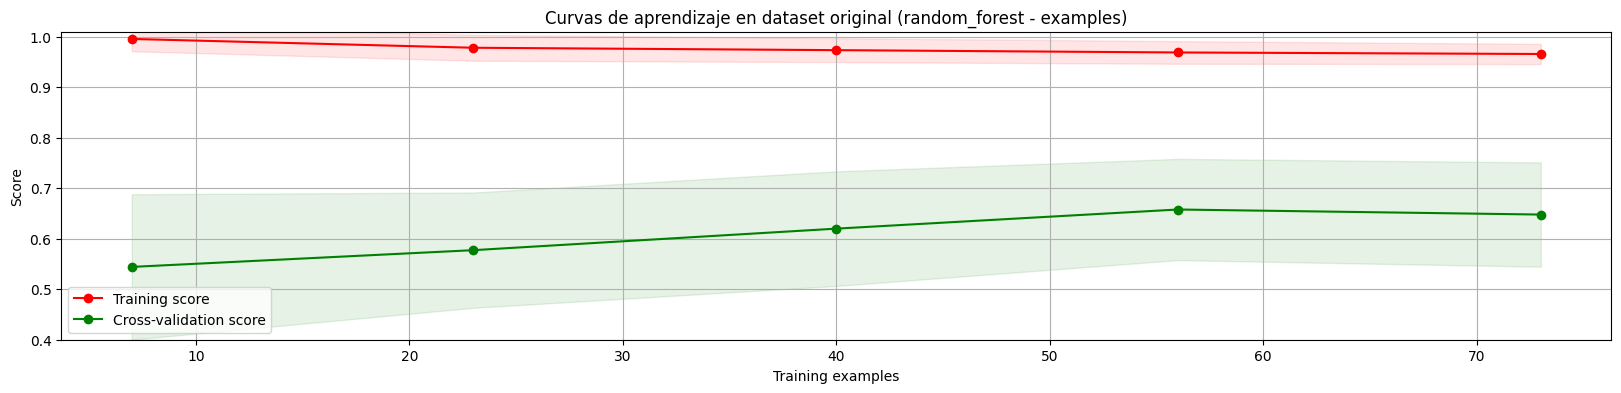

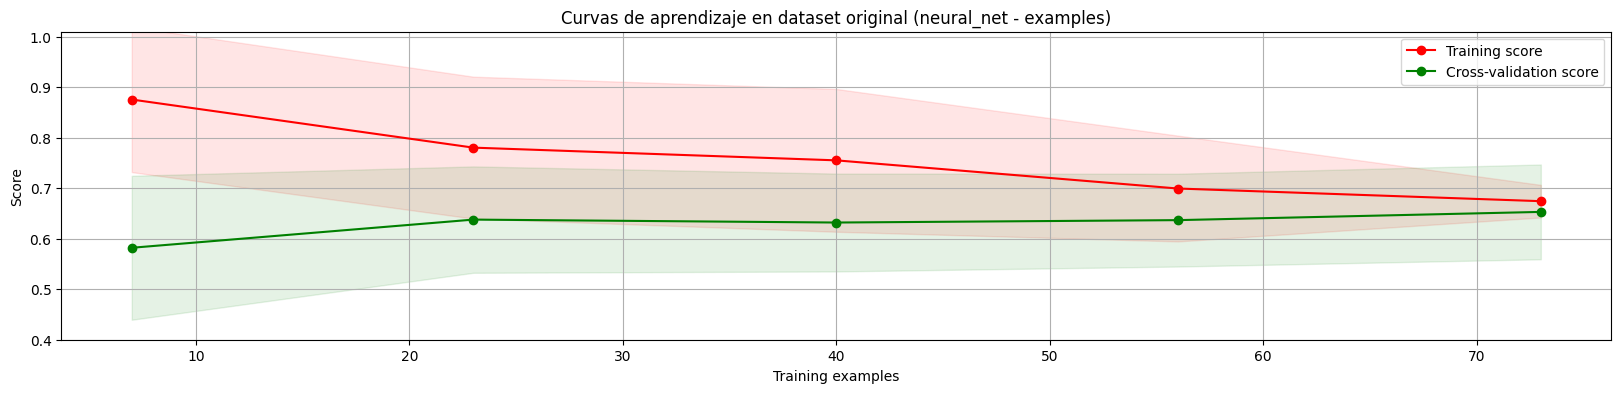

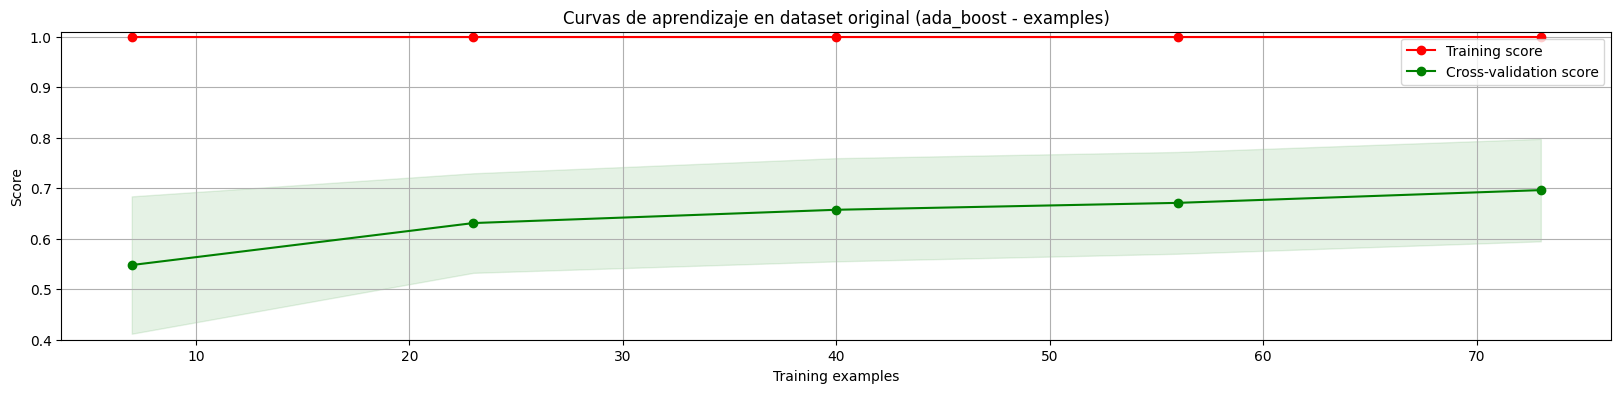

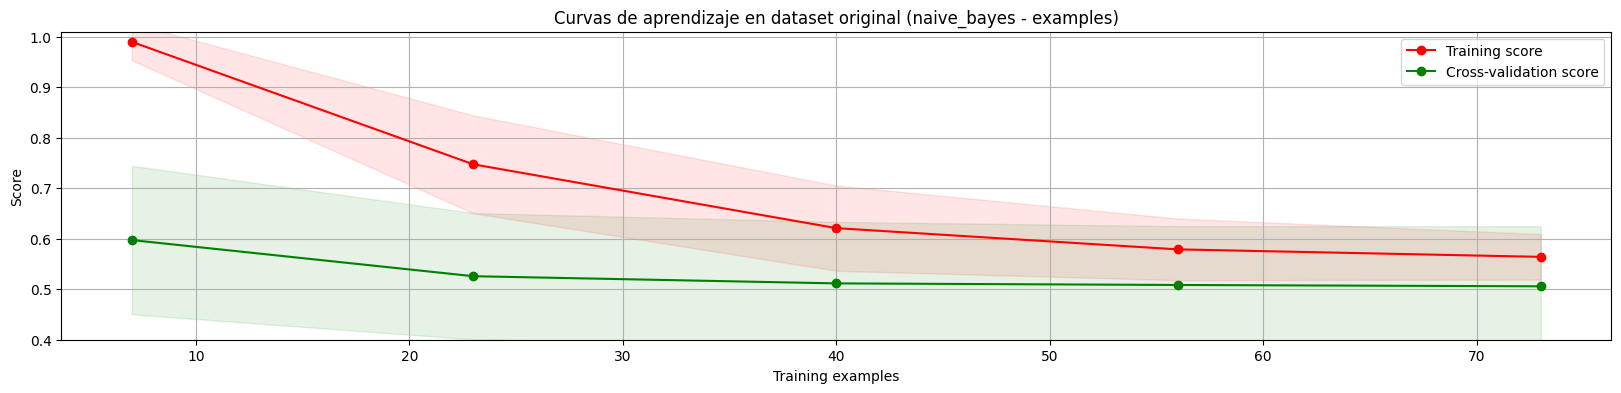

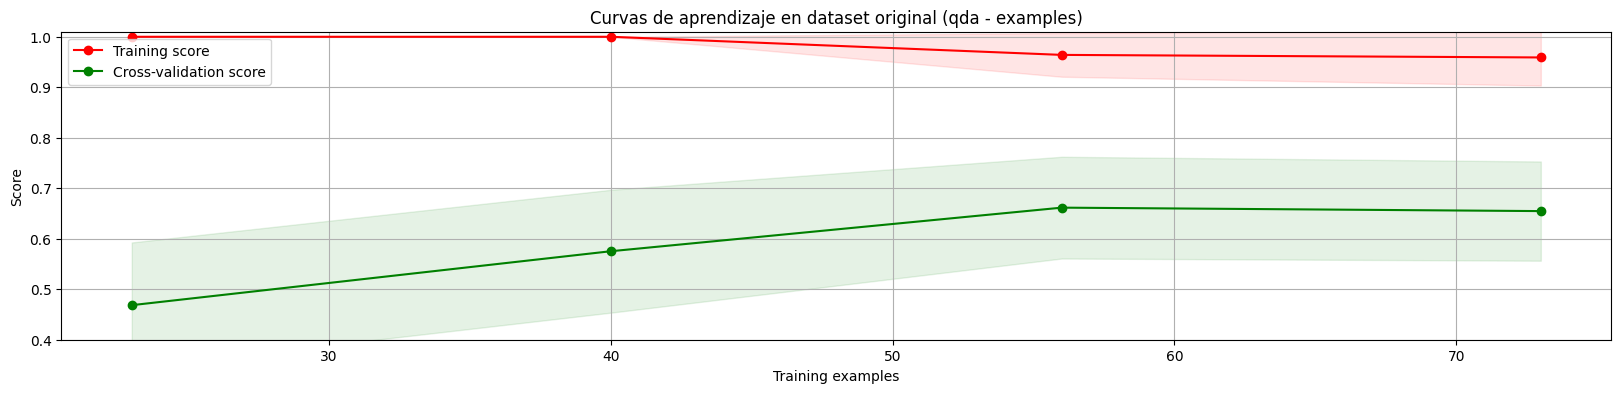

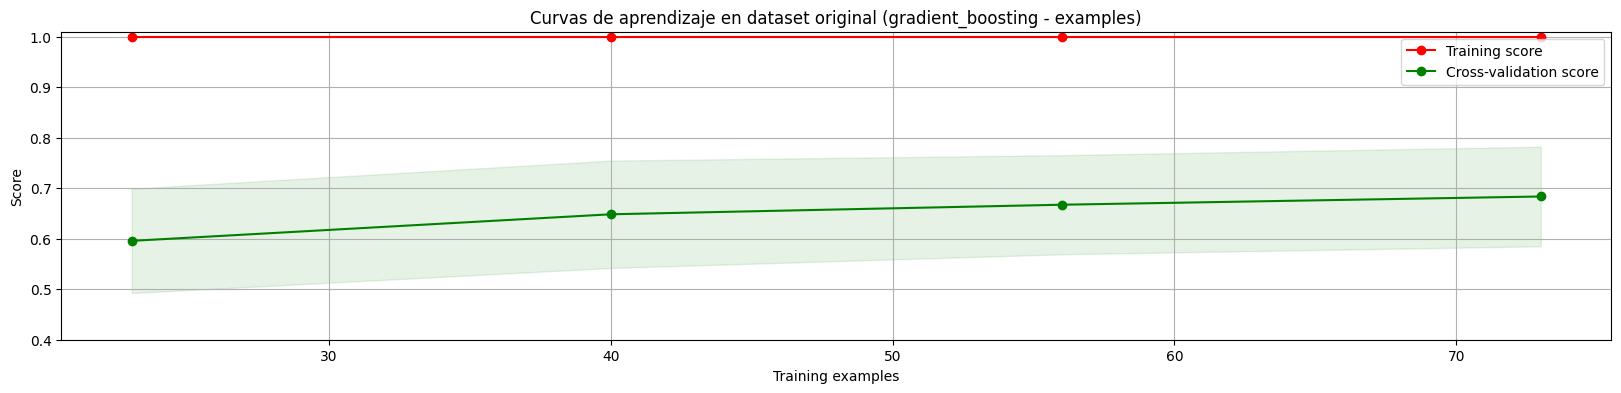

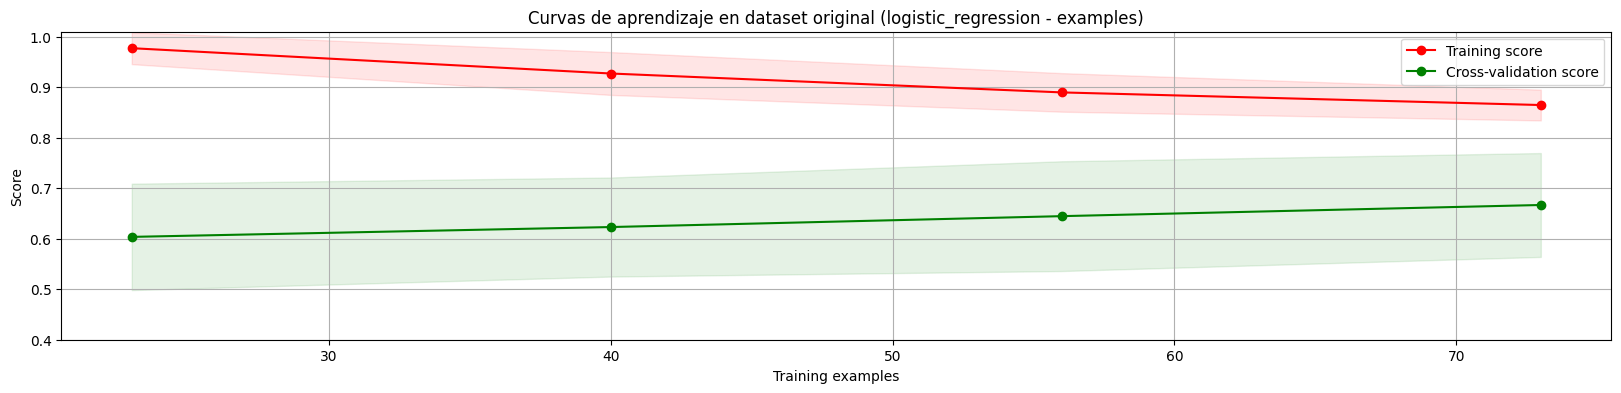

In [101]:
for classifier_name in classifiers:
    learning_curves_examples(
        file_path='../../resources/cleaned/cle_respuestas_form_1671774115.csv',
        classifier_name=classifier_name,
        dataset_name='original'
    )


### Dataset balanceado

#### Clasificación

In [102]:
url = f'{custom_evaluation_url}?file_path=bal_cle_respuestas_form_1671774115.csv'
file_balanced = post(url)['file_path']

#### Métricas

In [103]:
url = f'{metrics_custom_url}?file_path={file_balanced}'
file_balanced = post(url)['file_path']
df_balanced = dataset_service.read_dataset(
    file_path=f'../../resources/metrics/{file_balanced}',
    encoding='utf-8',
    delimiter=','
)
df_balanced.head()

algorithm  accuracy  sensitivity  specificity     kappa        f1  \
0  nearest_neighbors  0.548387          0.6       0.5000  0.099585  0.562500   
1         linear_svm  1.000000          1.0       1.0000  1.000000  1.000000   
2            rbf_svm  0.483871          1.0       0.0000  0.000000  0.652174   
3   gaussian_process  0.516129          0.6       0.4375  0.037267  0.545455   
4      decision_tree  1.000000          1.0       1.0000  1.000000  1.000000   

   precision  tp  fp  tn  fn       auc  
0   0.529412   9   6   8   8  0.531250  
1   1.000000  15   0  16   0  1.000000  
2   0.483871  15   0   0  16  0.437500  
3   0.500000   9   6   7   9  0.558333  
4   1.000000  15   0  16   0  1.000000

<AxesSubplot: title={'center': 'Métricas en dataset balanceado'}, xlabel='algorithm'>

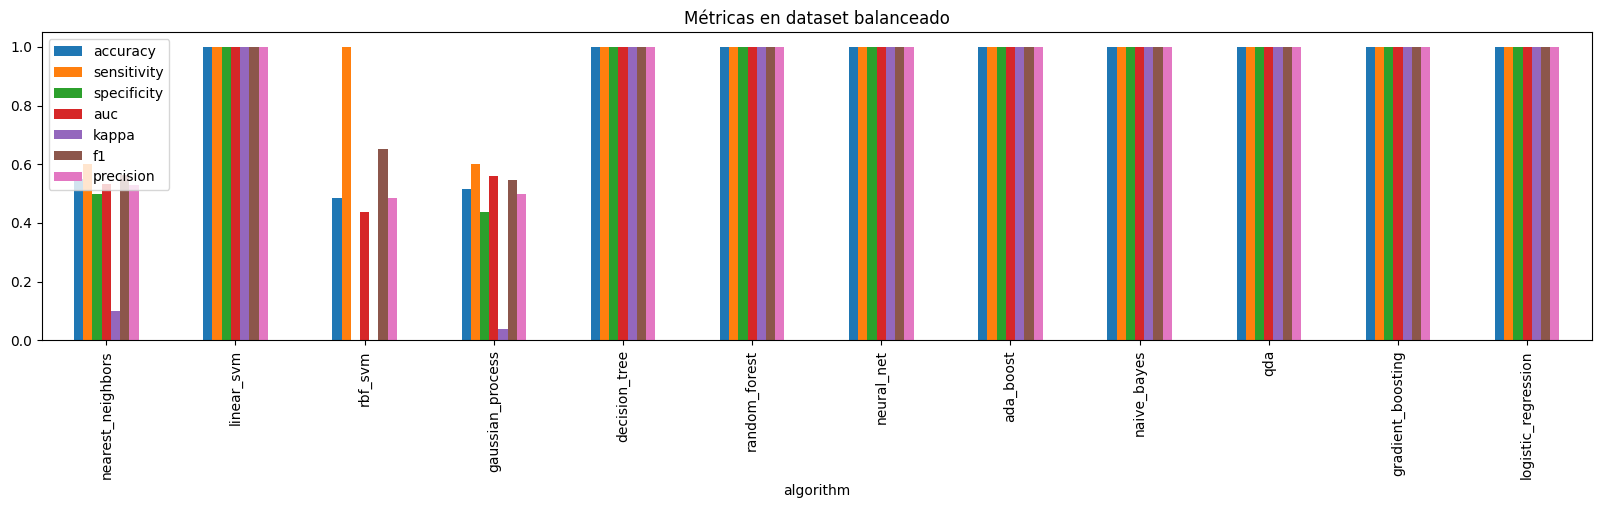

In [104]:
df_balanced[['algorithm'] + metrics].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Métricas en dataset balanceado'
)

<AxesSubplot: title={'center': 'Conteos en dataset balanceado'}, xlabel='algorithm'>

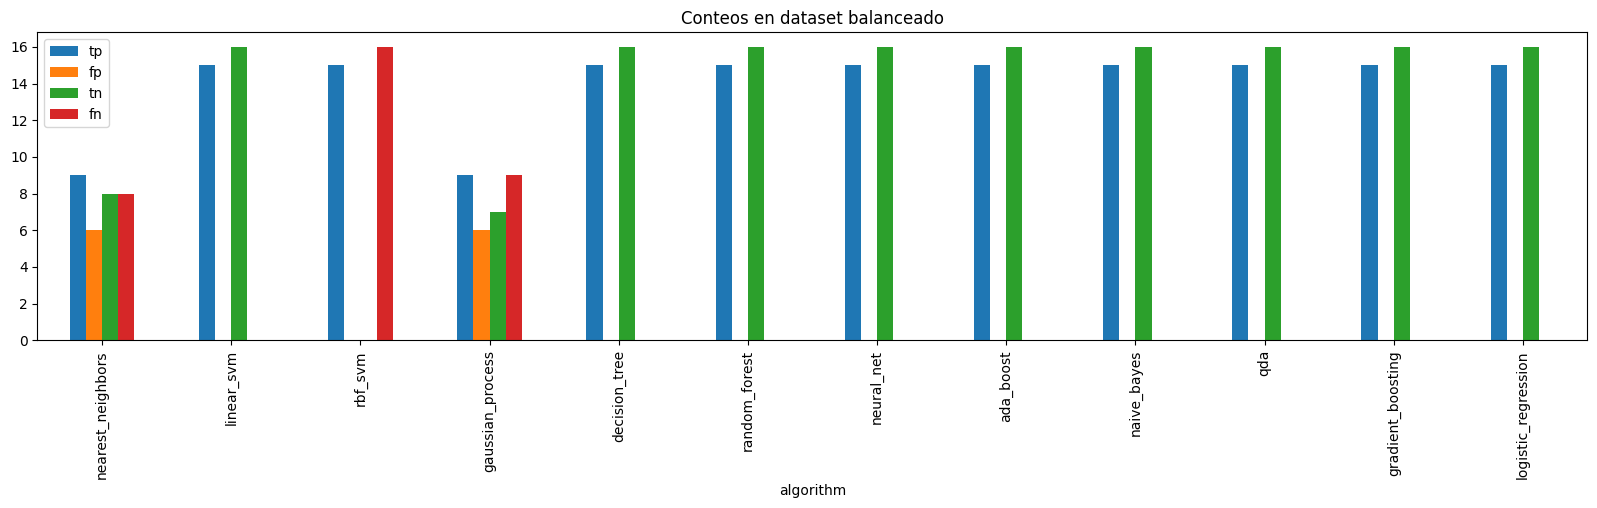

In [105]:
df_balanced[['algorithm'] + counts].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Conteos en dataset balanceado'
)

#### Curvas de aprendizaje

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e

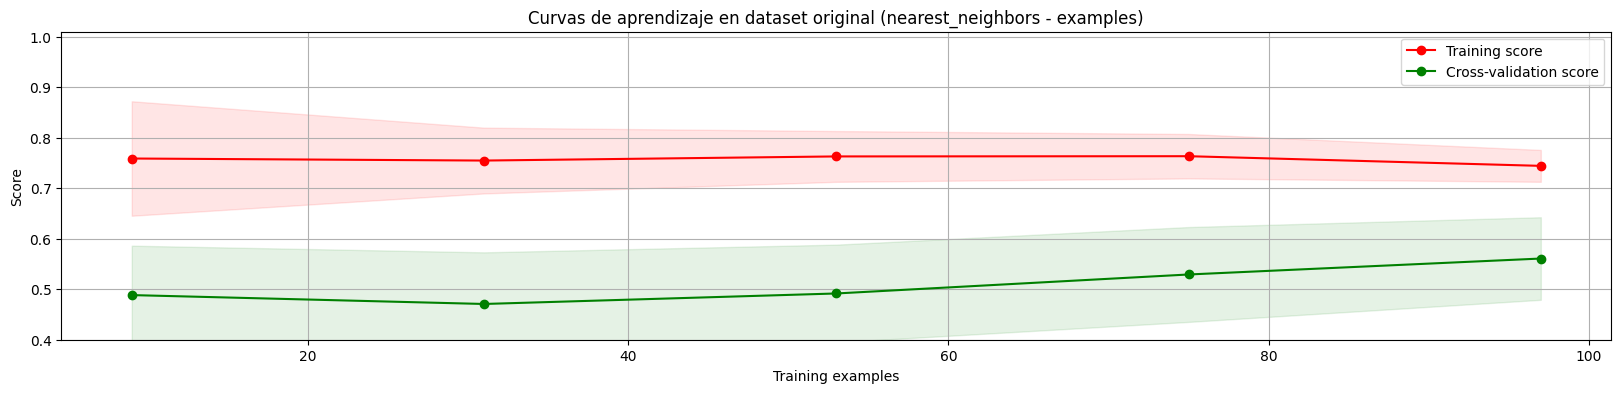

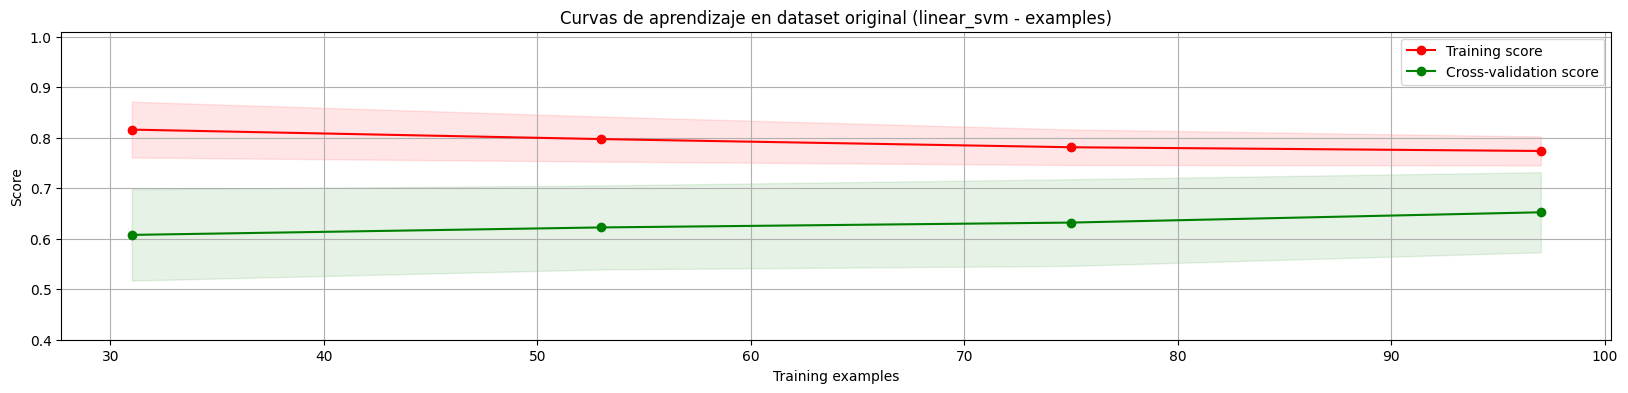

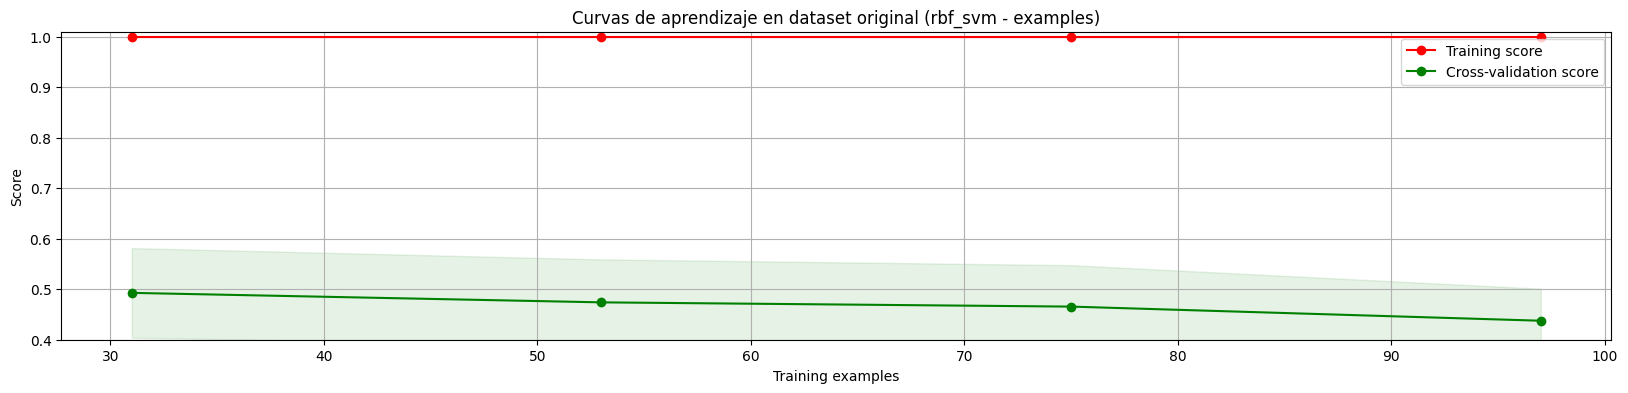

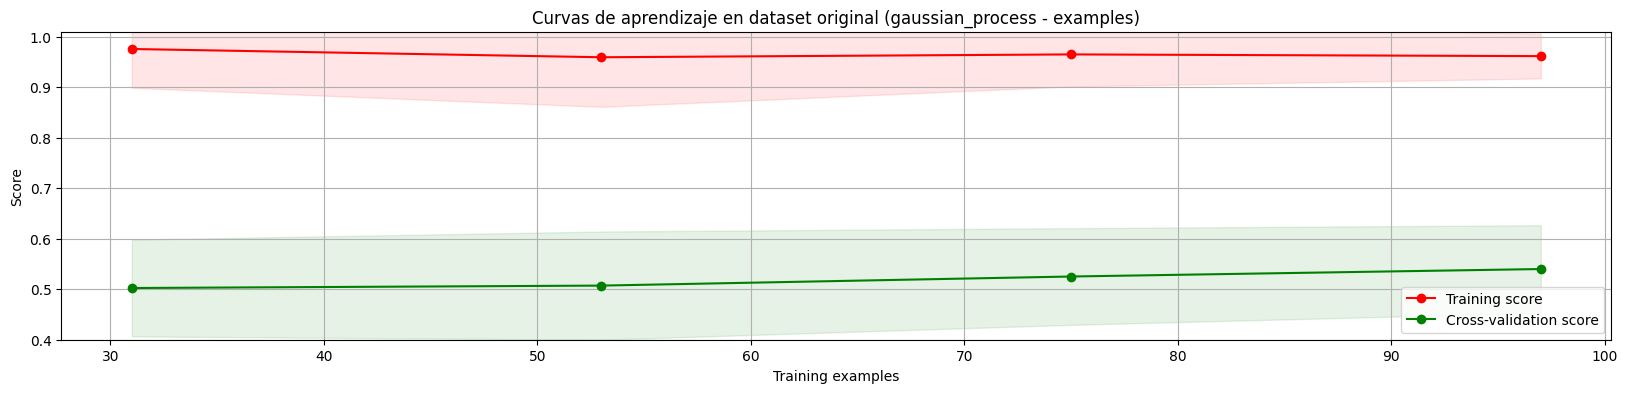

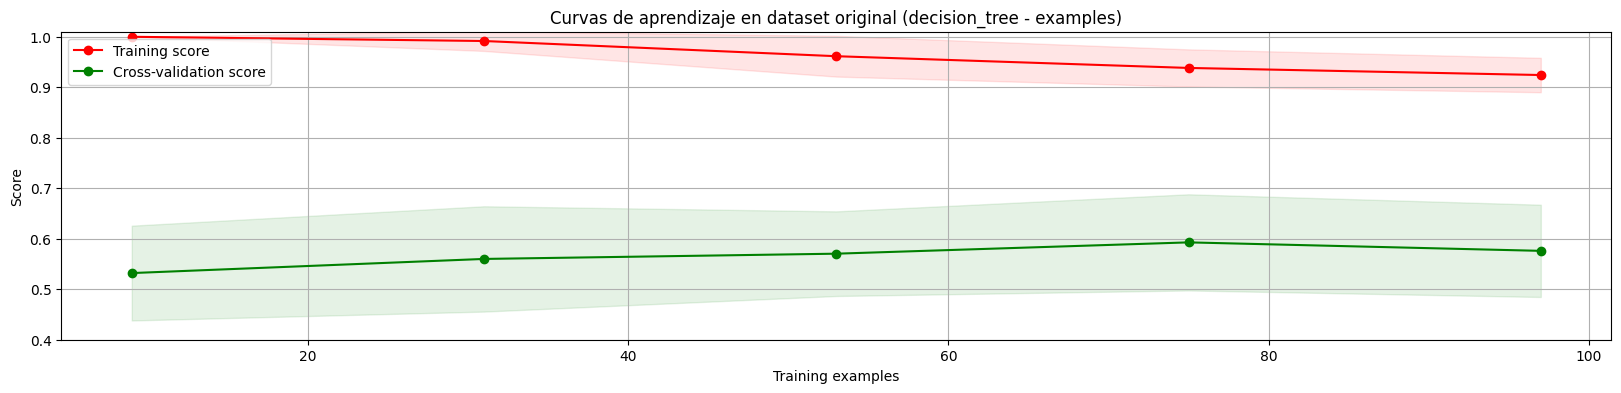

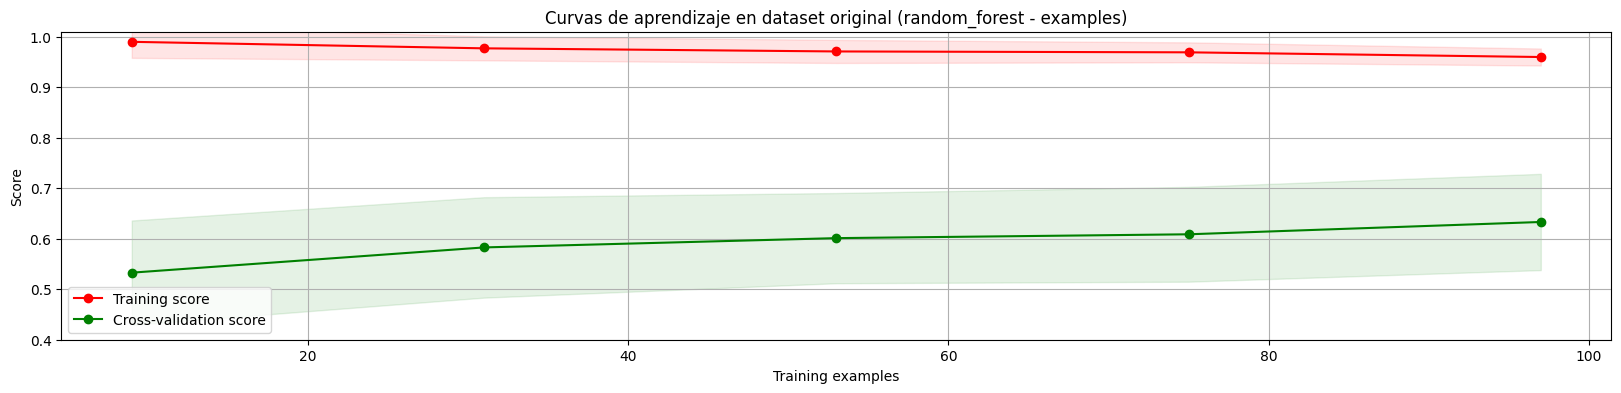

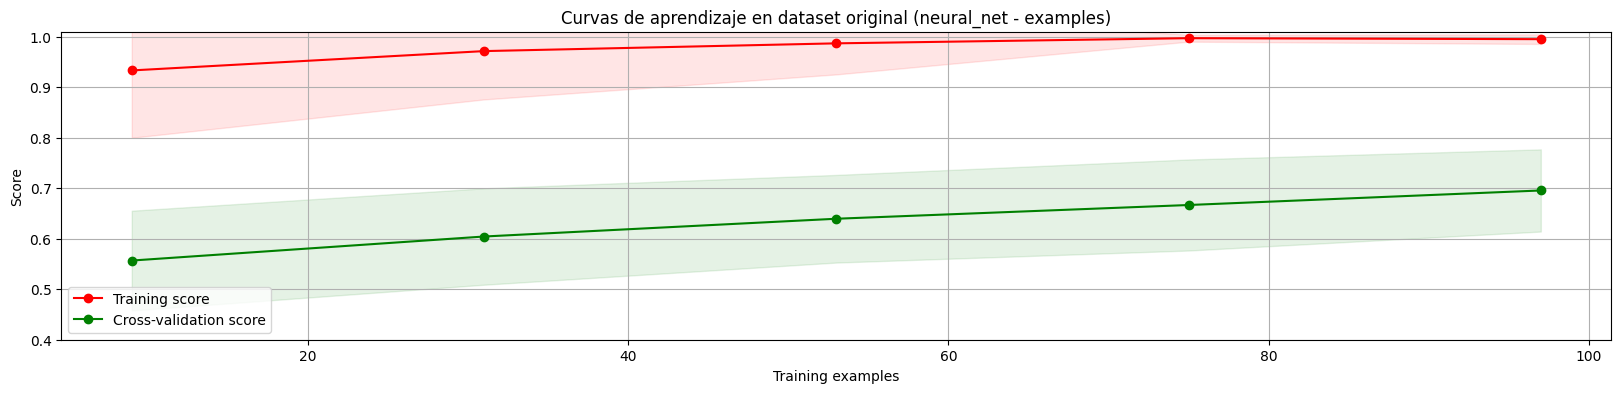

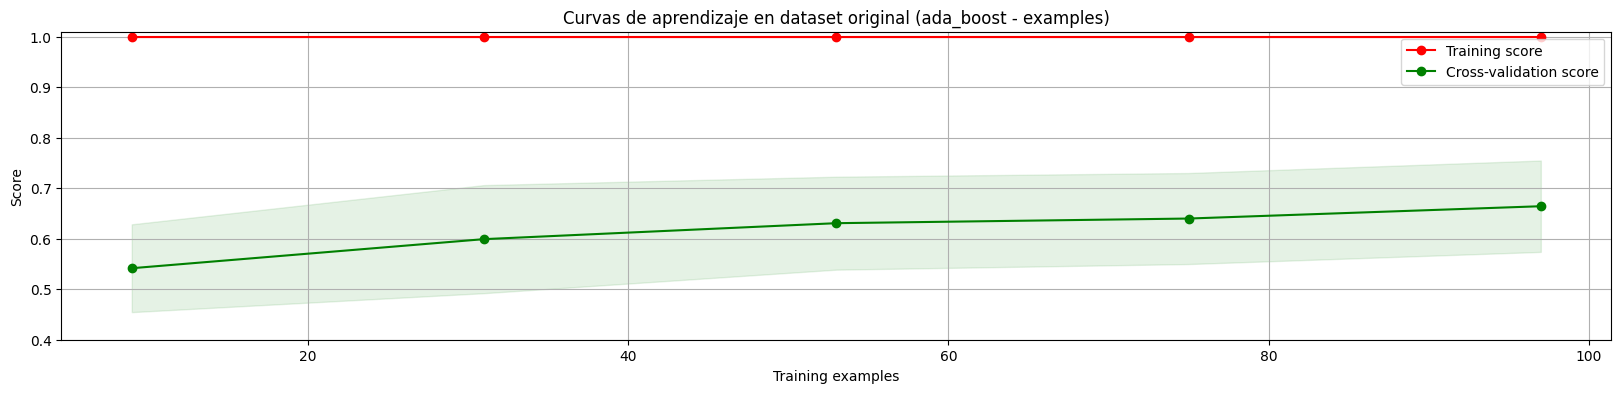

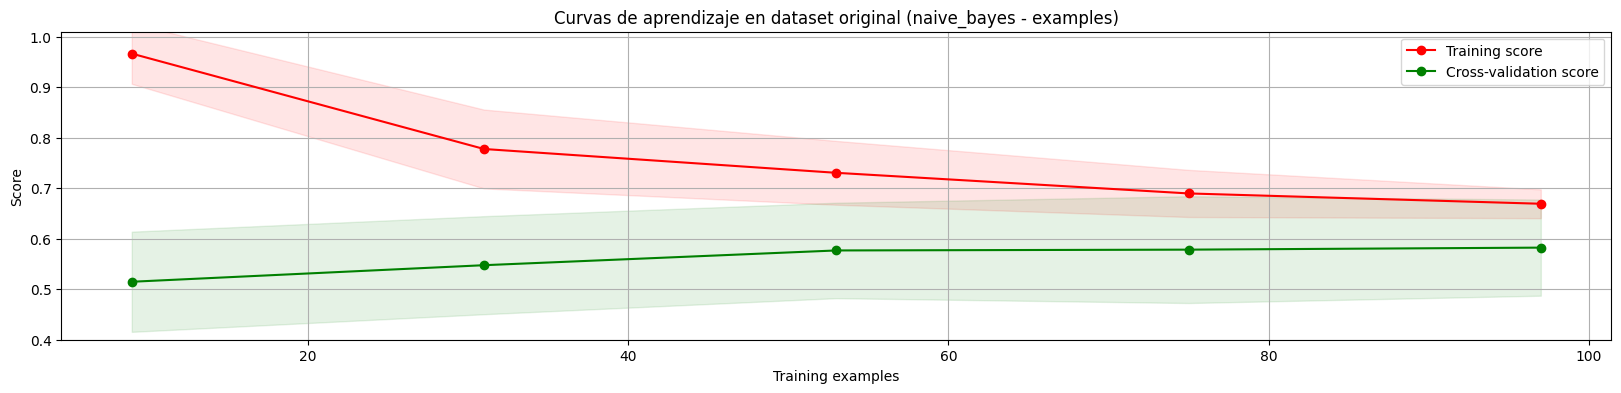

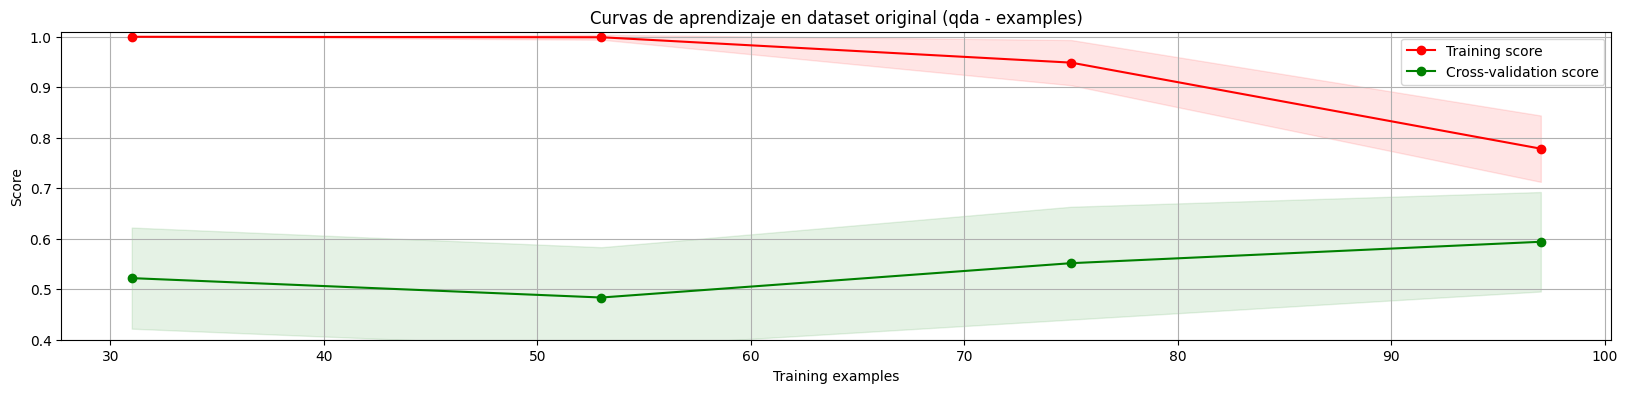

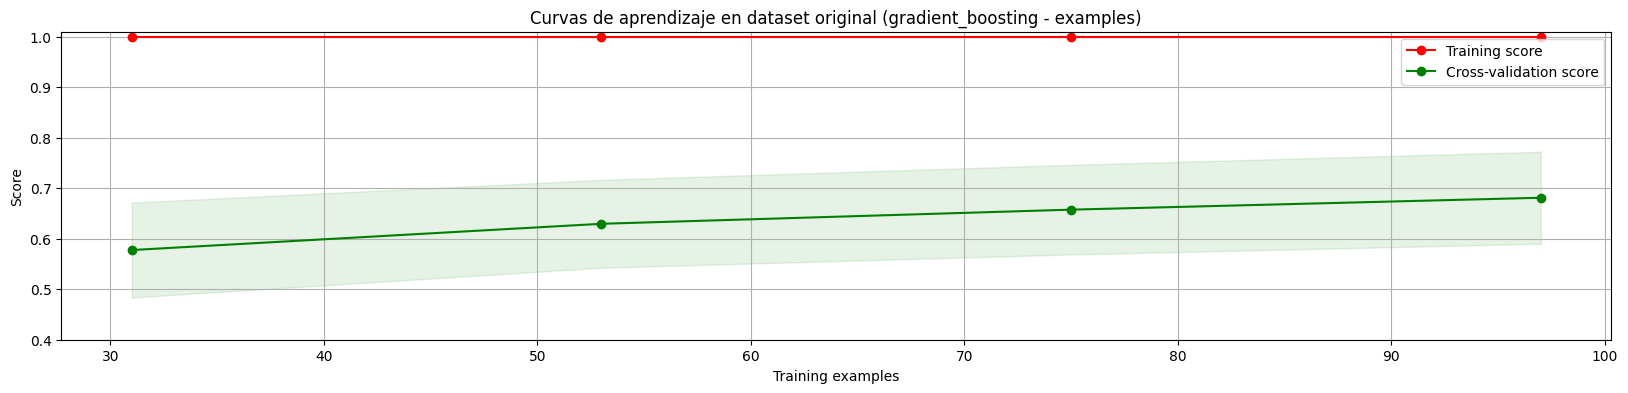

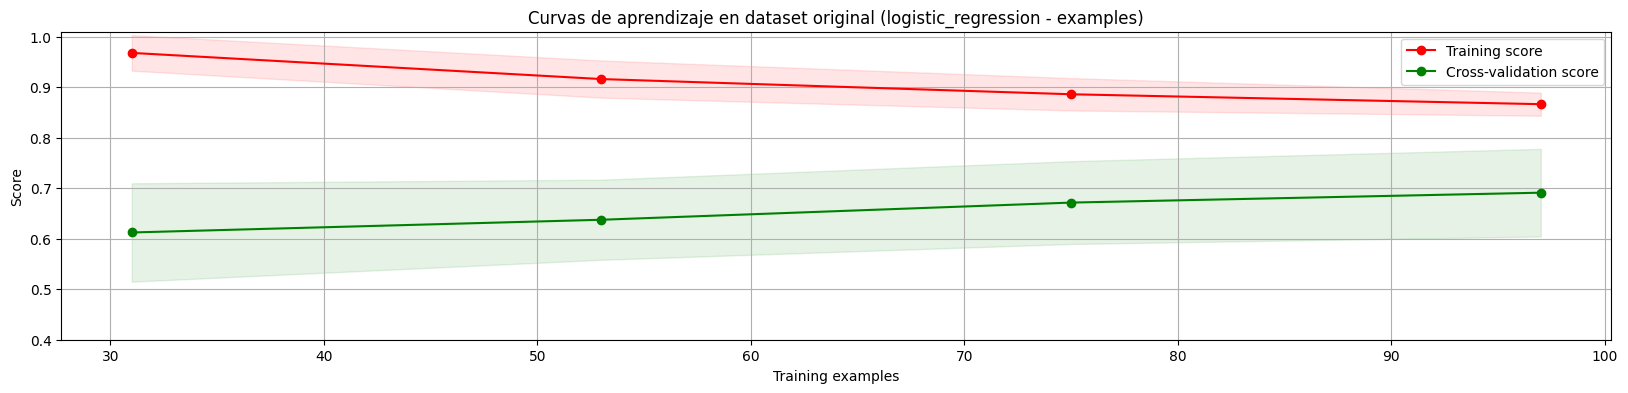

In [116]:
for classifier_name in classifiers:
    learning_curves_examples(
        file_path='../../resources/cleaned/bal_cle_respuestas_form_1671774115.csv',
        classifier_name=classifier_name,
        dataset_name='original'
    )

### Dataset original con extracción de características

#### Clasificación

In [106]:
url = f'{custom_evaluation_url}?file_path=ext_cle_respuestas_form_1671774115.csv'
file_original_ext = post(url)['file_path']

#### Métricas

In [107]:
url = f'{metrics_custom_url}?file_path={file_original_ext}'
file_original_ext = post(url)['file_path']
df_original_ext = dataset_service.read_dataset(
    file_path=f'../../resources/metrics/{file_original_ext}',
    encoding='utf-8',
    delimiter=','
)
df_original_ext.head()

algorithm  accuracy  sensitivity  specificity     kappa        f1  \
0  nearest_neighbors  0.956522     0.941176          1.0  0.893023  0.969697   
1         linear_svm  1.000000     1.000000          1.0  1.000000  1.000000   
2            rbf_svm  0.739130     1.000000          0.0  0.000000  0.850000   
3   gaussian_process  1.000000     1.000000          1.0  1.000000  1.000000   
4      decision_tree  1.000000     1.000000          1.0  1.000000  1.000000   

   precision  tp  fp  tn  fn       auc  
0    1.00000  16   1   6   0  0.985294  
1    1.00000  17   0   6   0  1.000000  
2    0.73913  17   0   0   6  0.078431  
3    1.00000  17   0   6   0  1.000000  
4    1.00000  17   0   6   0  1.000000

<AxesSubplot: title={'center': 'Métricas en dataset original con extracción de características'}, xlabel='algorithm'>

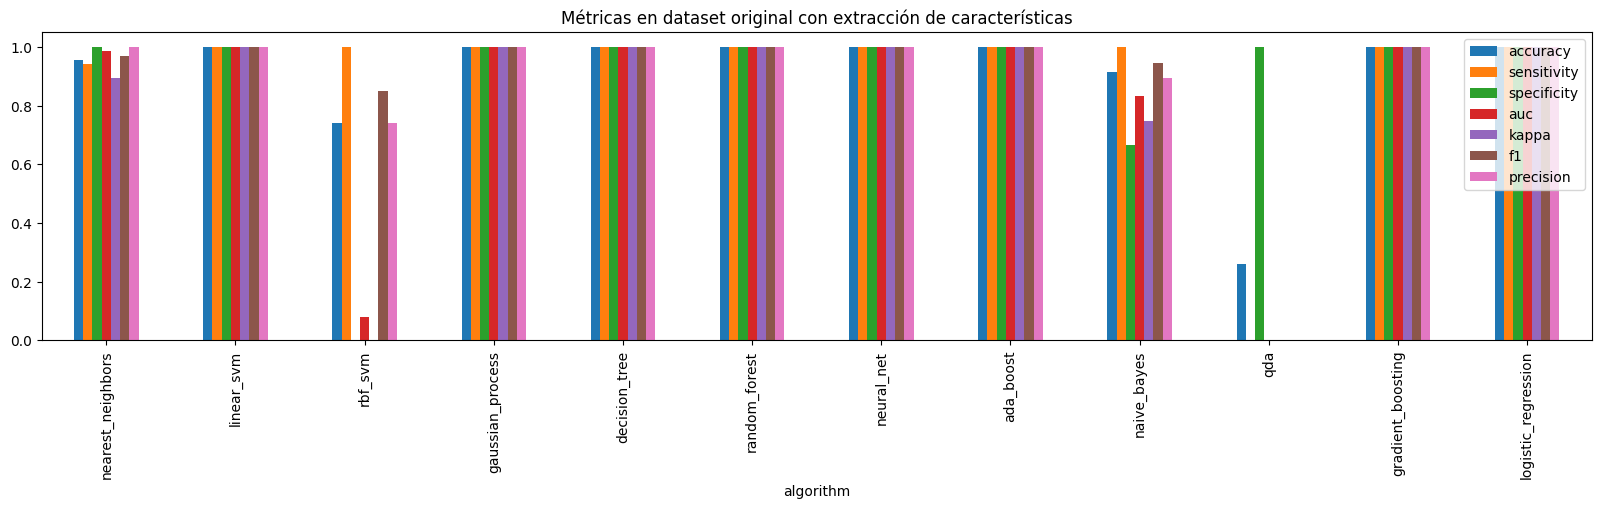

In [108]:
df_original_ext[['algorithm'] + metrics].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Métricas en dataset original con extracción de características'
)

<AxesSubplot: title={'center': 'Conteos en dataset original con extracción de características'}, xlabel='algorithm'>

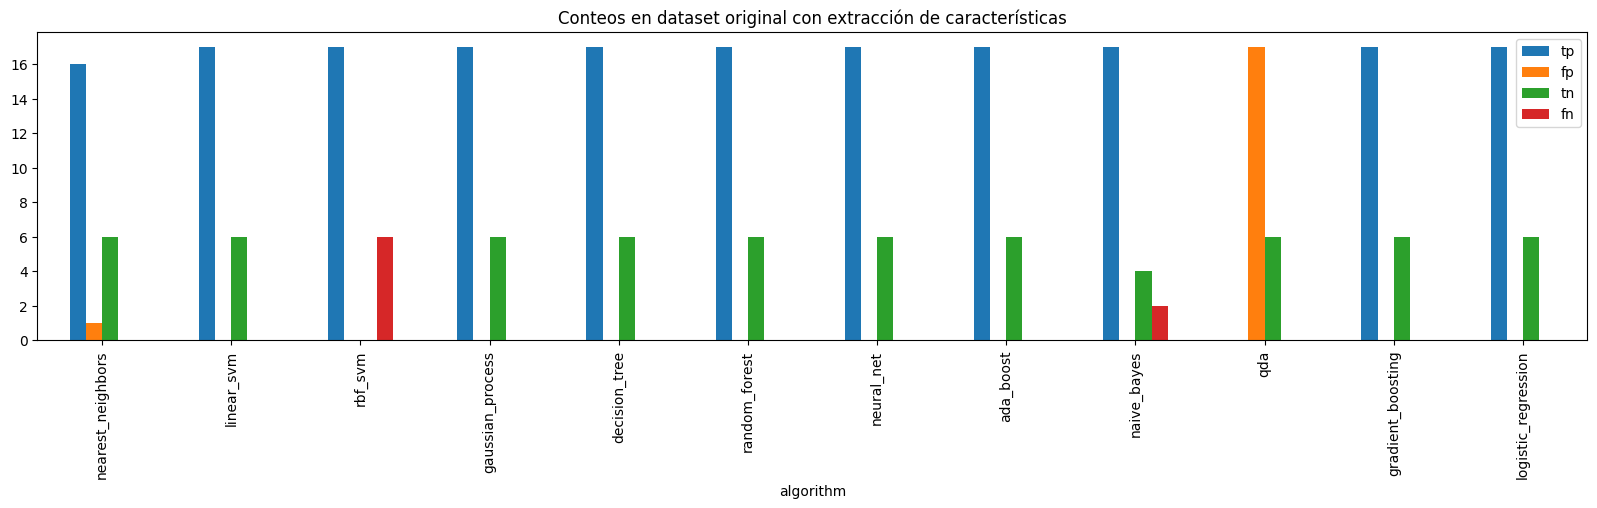

In [109]:
df_original_ext[['algorithm'] + counts].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Conteos en dataset original con extracción de características'
)

#### Curvas de aprendizaje

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1000

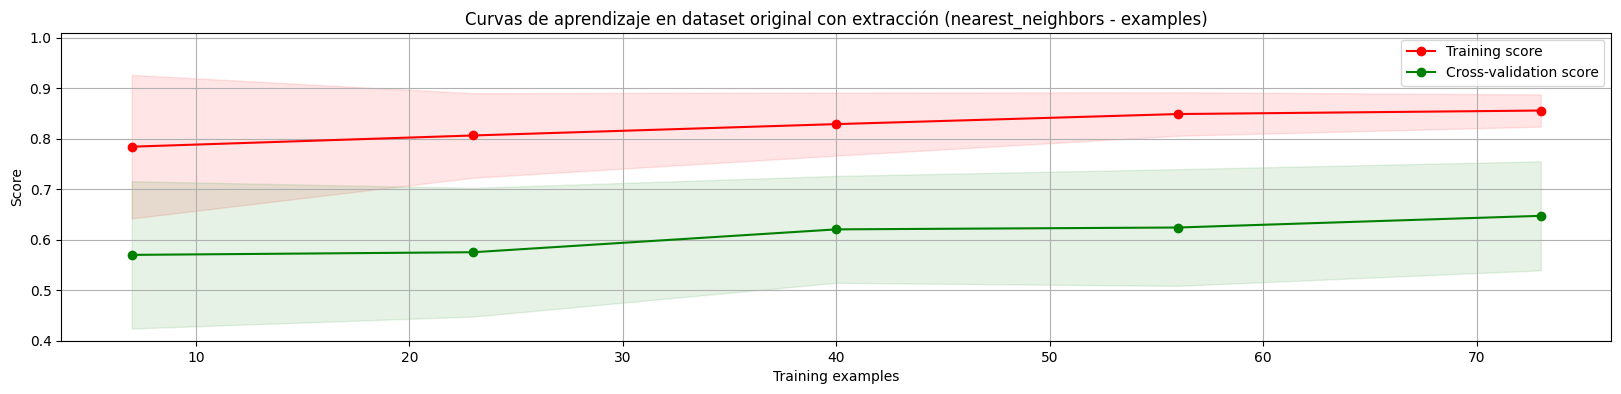

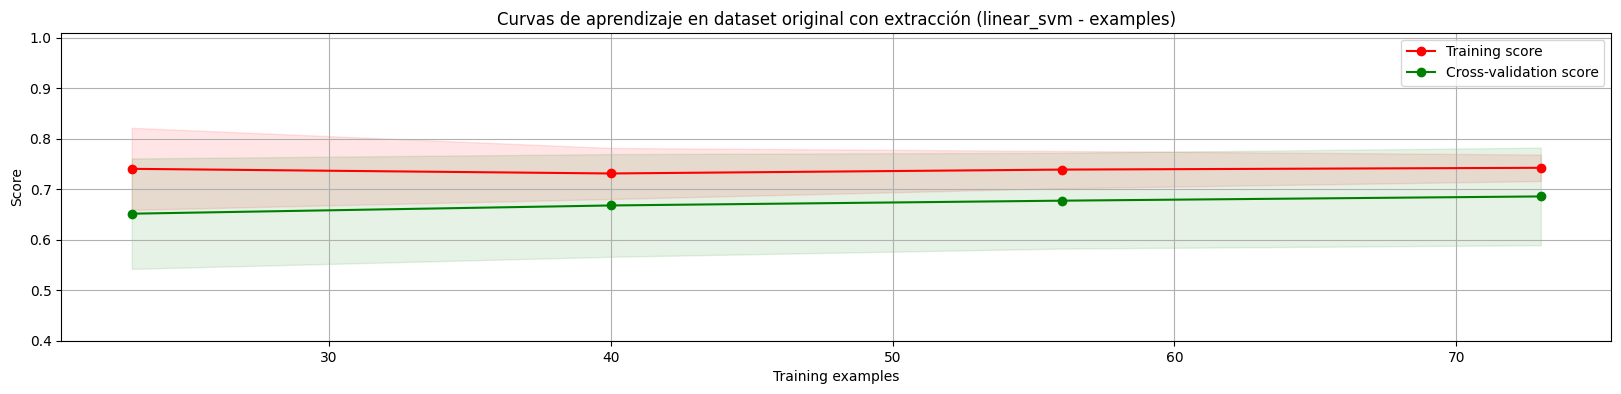

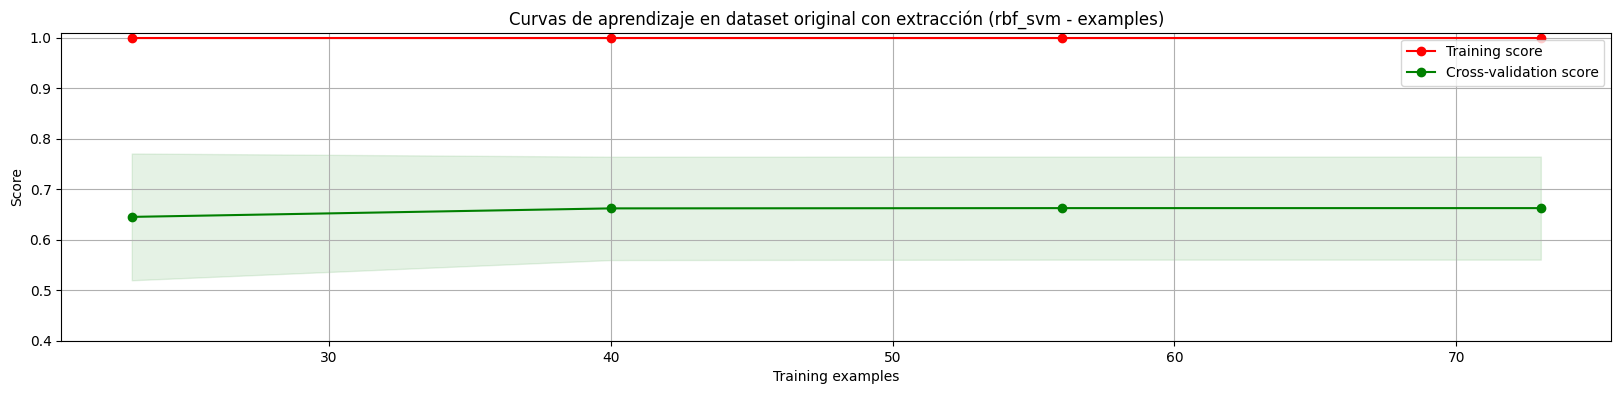

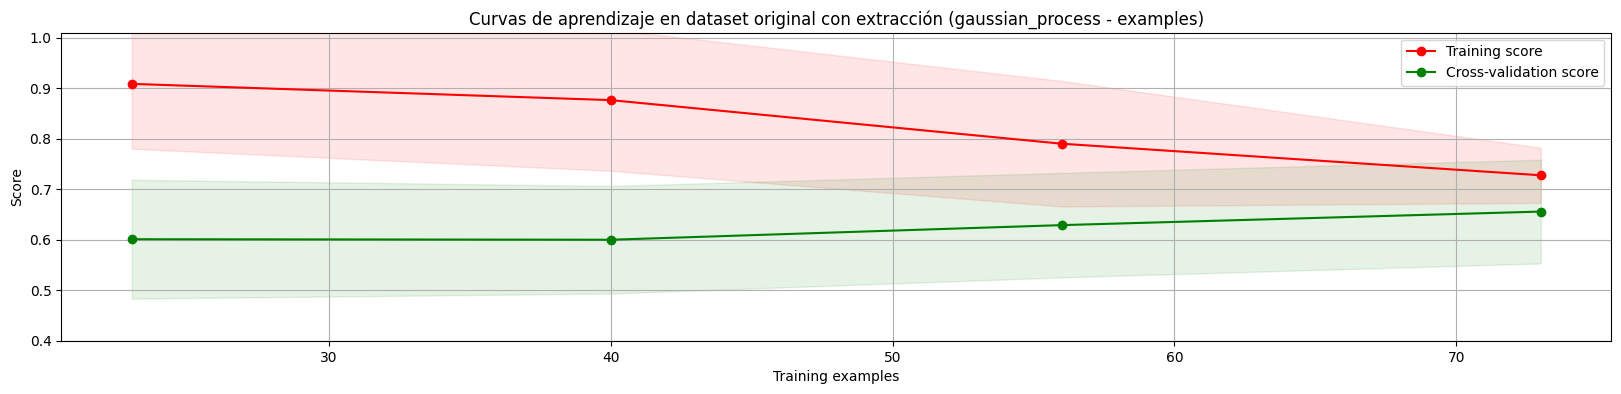

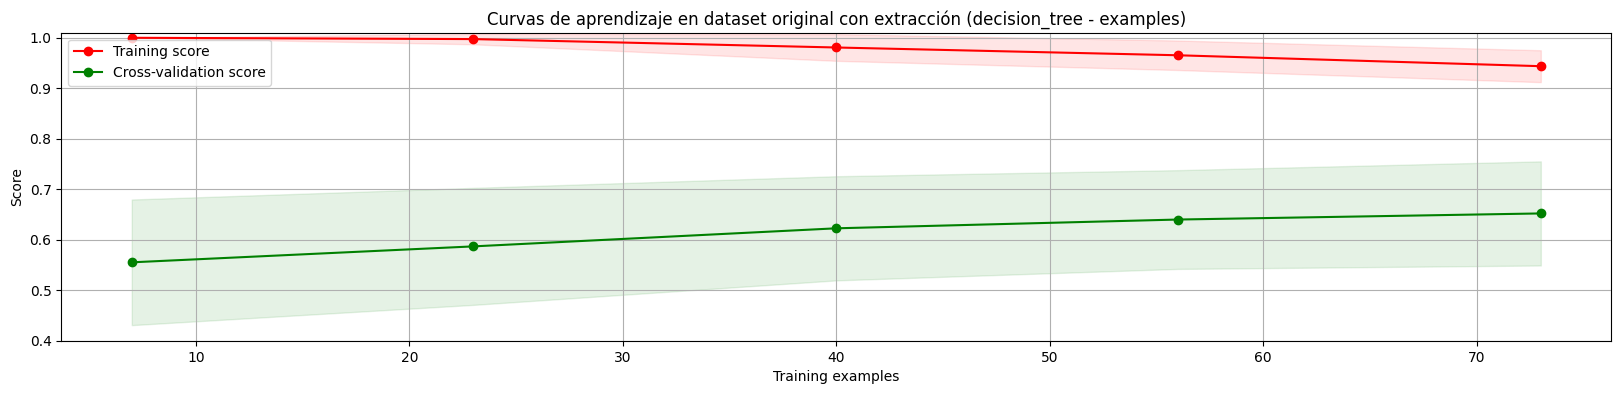

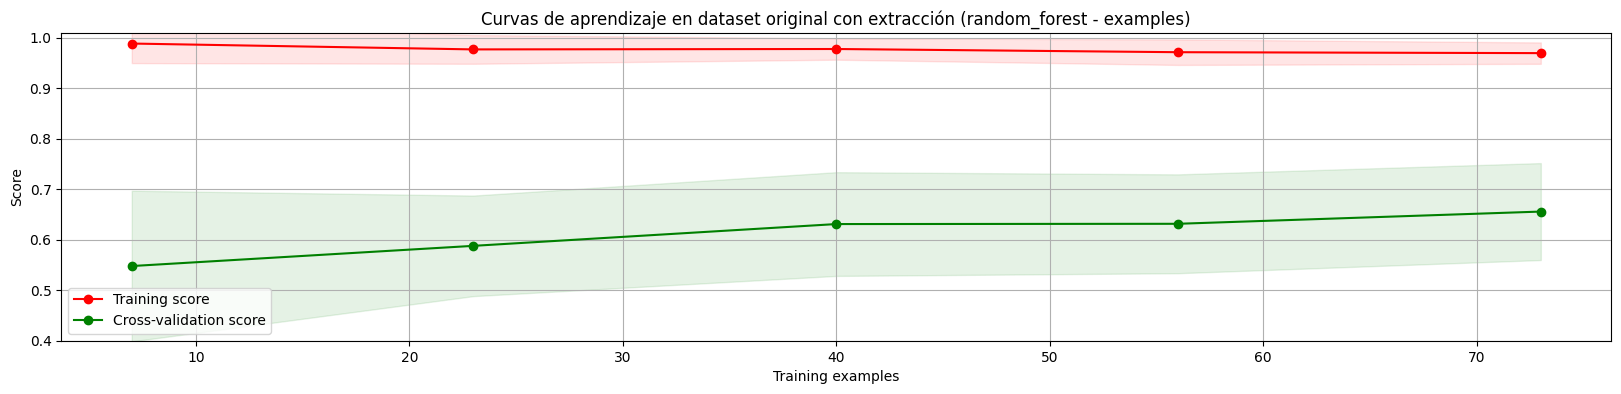

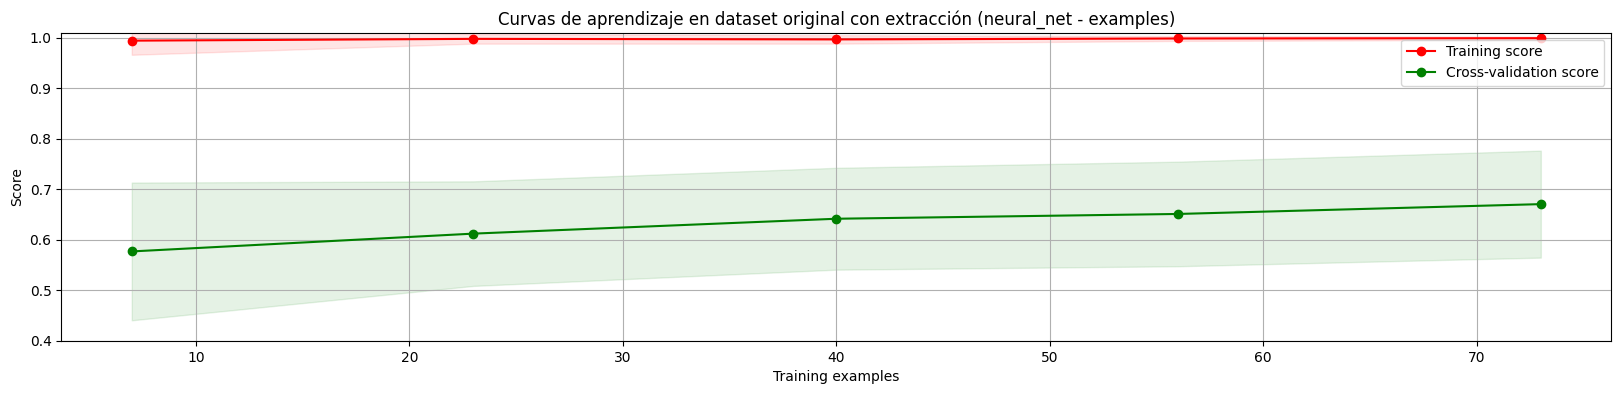

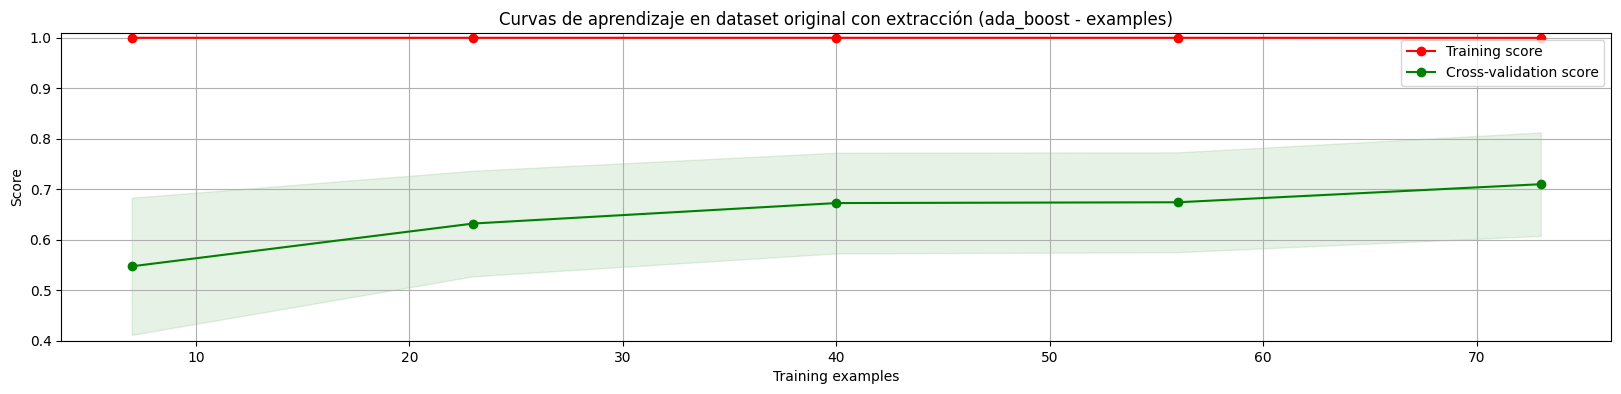

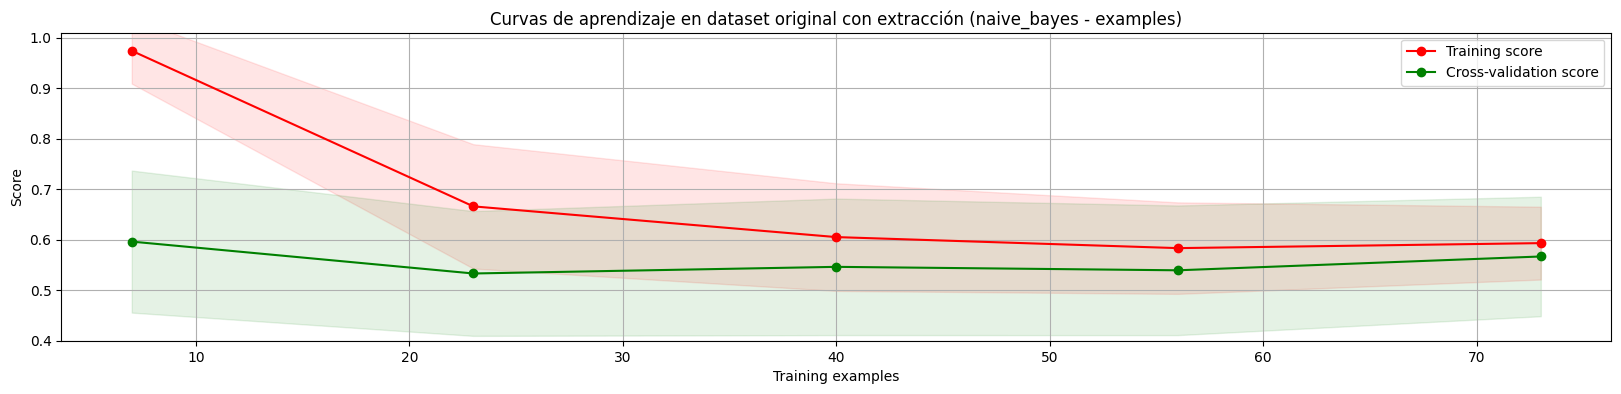

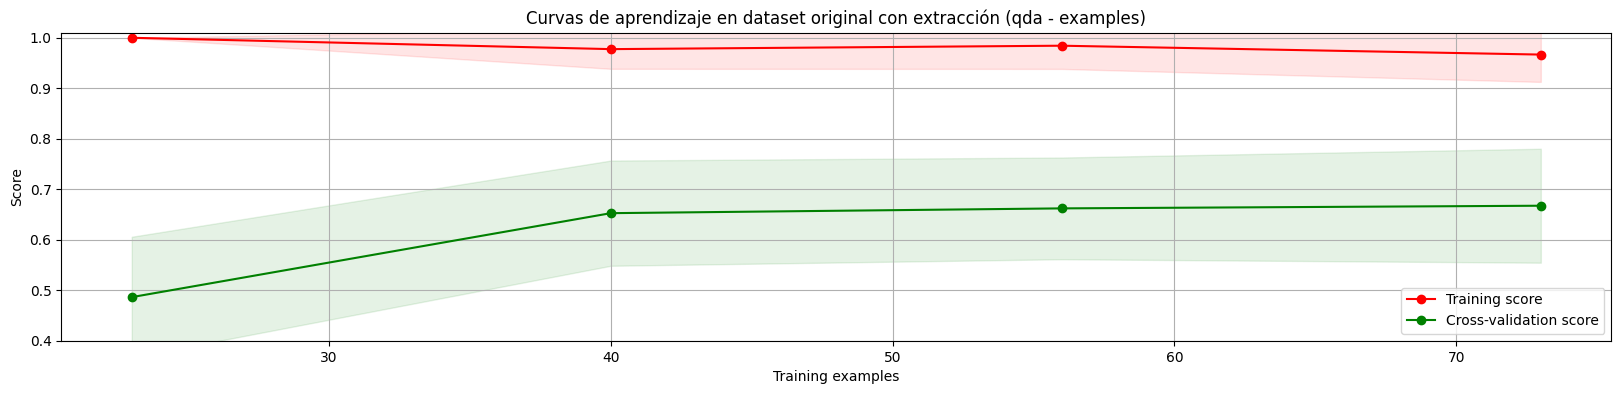

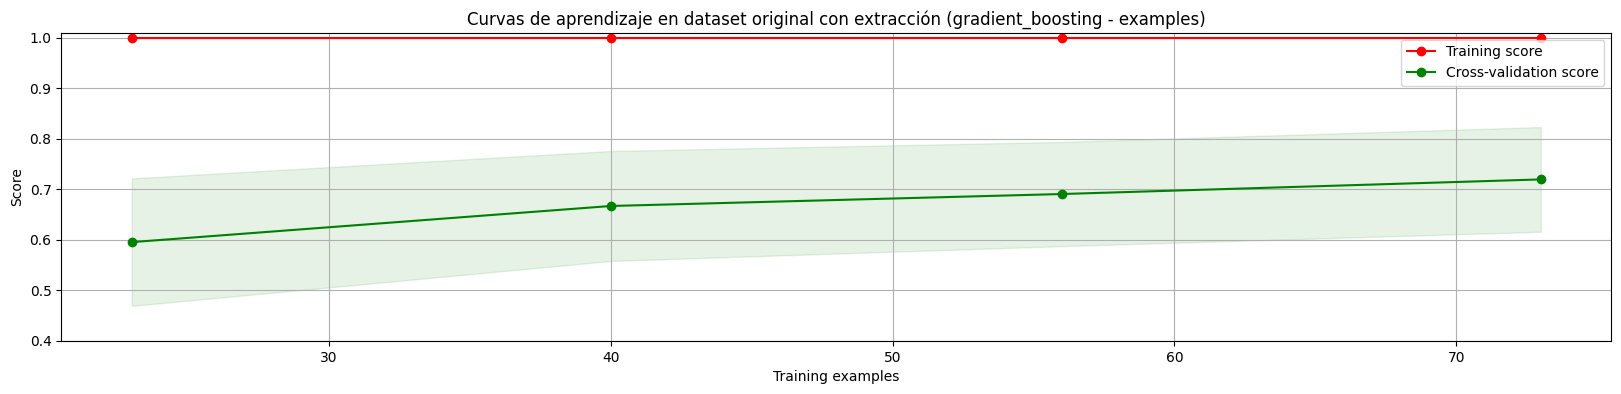

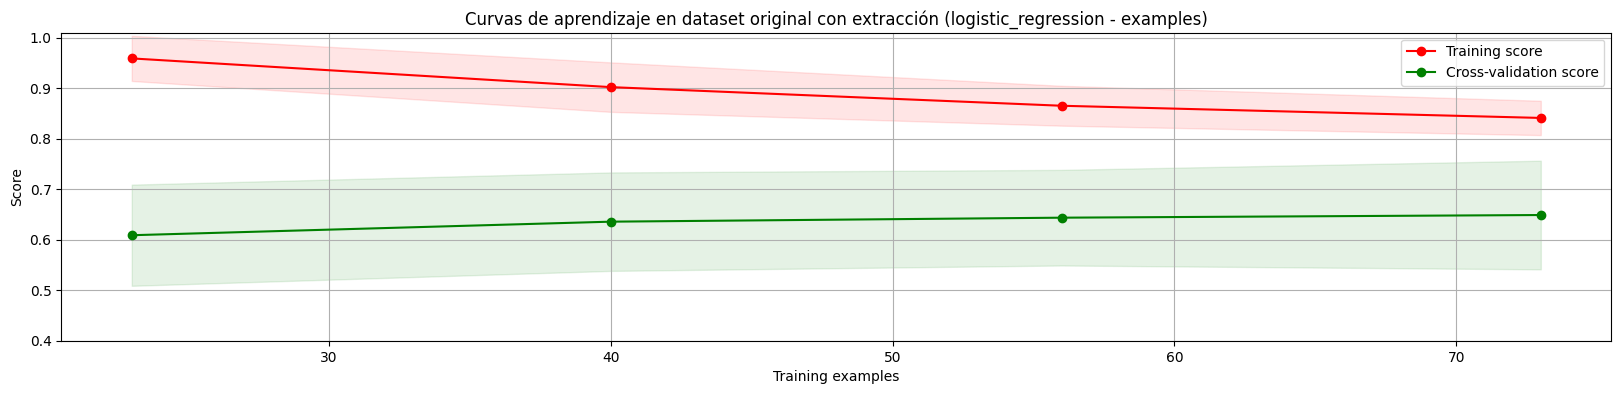

In [117]:
for classifier_name in classifiers:
    learning_curves_examples(
        file_path='../../resources/cleaned/ext_cle_respuestas_form_1671774115.csv',
        classifier_name=classifier_name,
        dataset_name='original con extracción'
    )

### Dataset balanceado con extracción de características

#### Clasificación

In [110]:
url = f'{custom_evaluation_url}?file_path=ext_bal_cle_respuestas_form_1671774115.csv'
file_balanced_ext = post(url)['file_path']

#### Métricas

In [111]:
url = f'{metrics_custom_url}?file_path={file_balanced_ext}'
file_balanced_ext = post(url)['file_path']
df_balanced_ext = dataset_service.read_dataset(
    file_path=f'../../resources/metrics/{file_balanced_ext}',
    encoding='utf-8',
    delimiter=','
)
df_balanced_ext.head()

algorithm  accuracy  sensitivity  specificity     kappa        f1  \
0  nearest_neighbors  0.806452          0.6          1.0  0.607595  0.750000   
1         linear_svm  1.000000          1.0          1.0  1.000000  1.000000   
2            rbf_svm  0.483871          1.0          0.0  0.000000  0.652174   
3   gaussian_process  1.000000          1.0          1.0  1.000000  1.000000   
4      decision_tree  1.000000          1.0          1.0  1.000000  1.000000   

   precision  tp  fp  tn  fn      auc  
0   1.000000   9   6  16   0  0.98750  
1   1.000000  15   0  16   0  1.00000  
2   0.483871  15   0   0  16  0.21875  
3   1.000000  15   0  16   0  1.00000  
4   1.000000  15   0  16   0  1.00000

<AxesSubplot: title={'center': 'Métricas en dataset balanceado con extracción de características'}, xlabel='algorithm'>

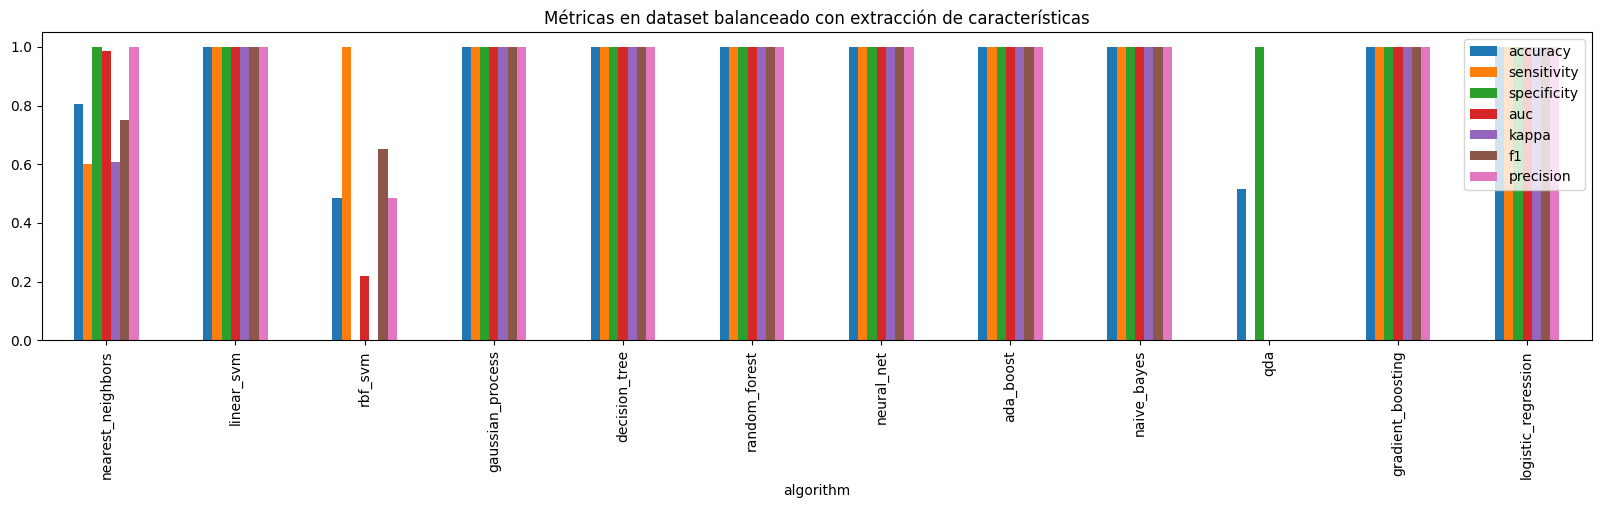

In [112]:
df_balanced_ext[['algorithm'] + metrics].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Métricas en dataset balanceado con extracción de características'
)

<AxesSubplot: title={'center': 'Conteos en dataset balanceado con extracción de características'}, xlabel='algorithm'>

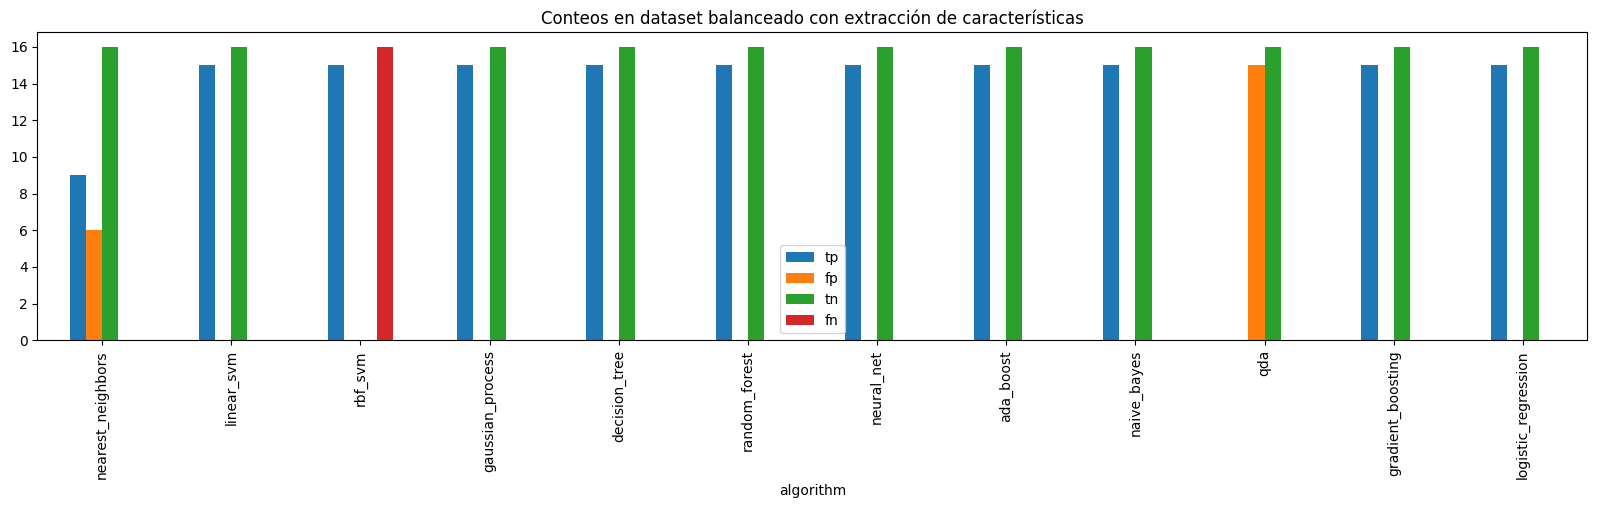

In [113]:
df_balanced_ext[['algorithm'] + counts].plot.bar(
    x='algorithm',
    figsize=(20, 4),
    title='Conteos en dataset balanceado con extracción de características'
)

#### Curvas de aprendizaje

/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/porfirioads/.local/share/virtualenvs/mcpi-tesis-backend-lmykv_dJ/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-

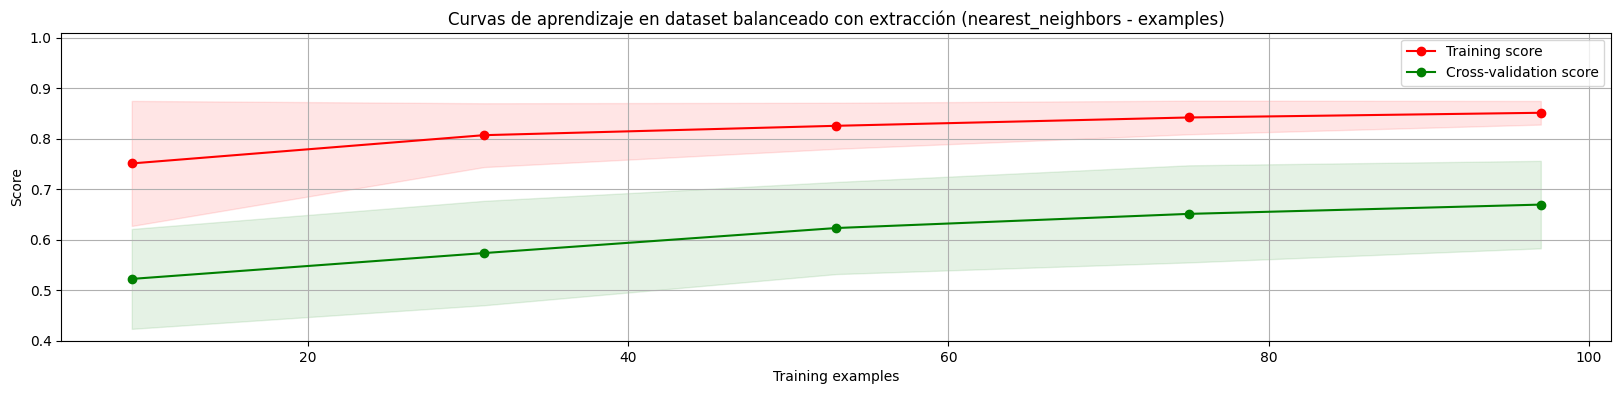

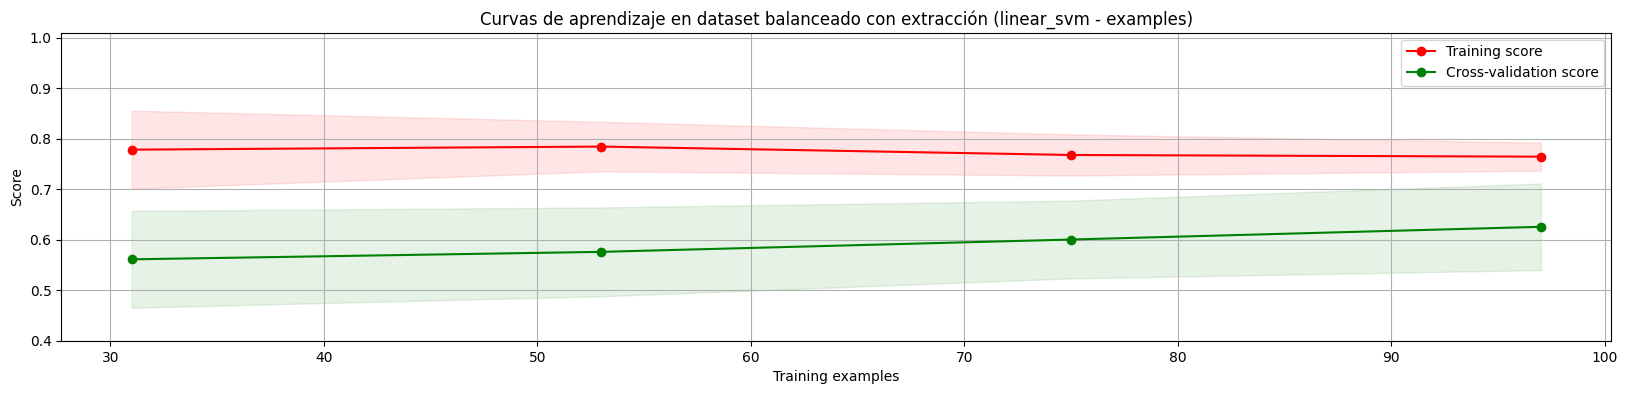

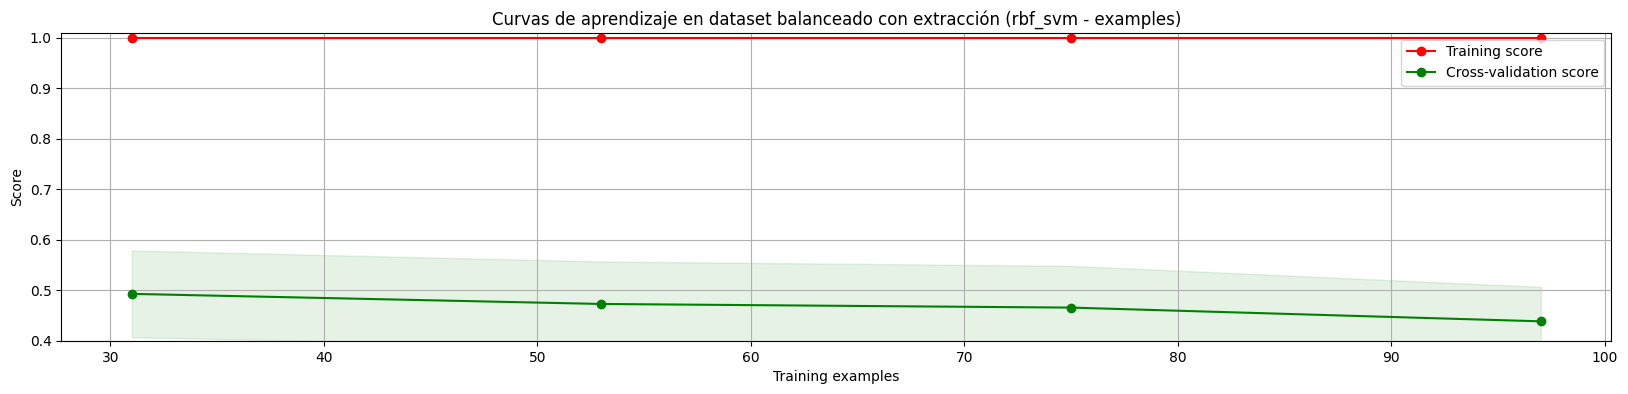

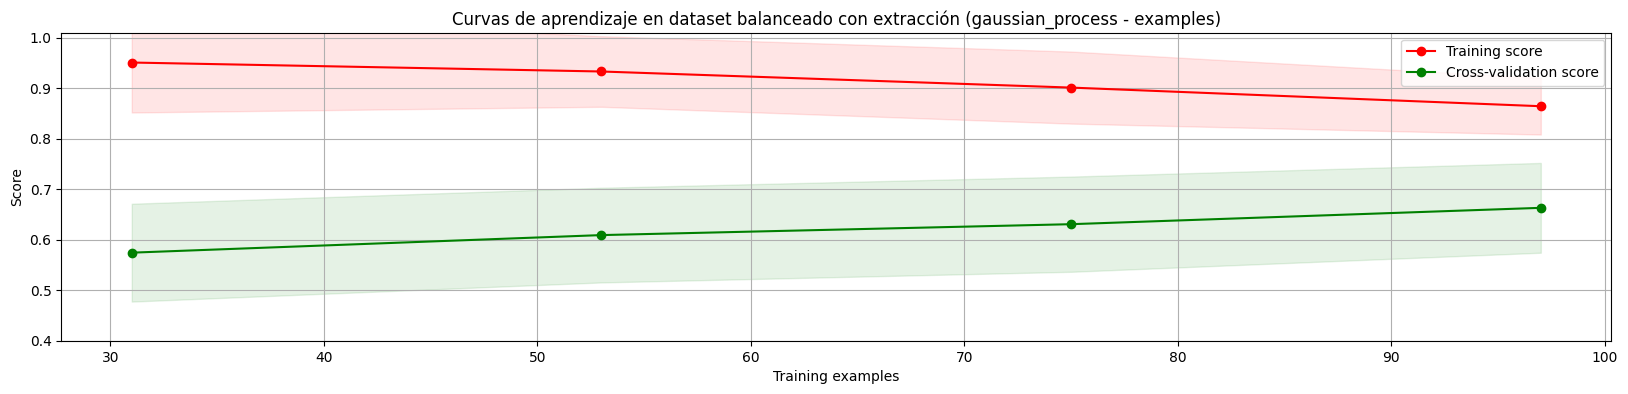

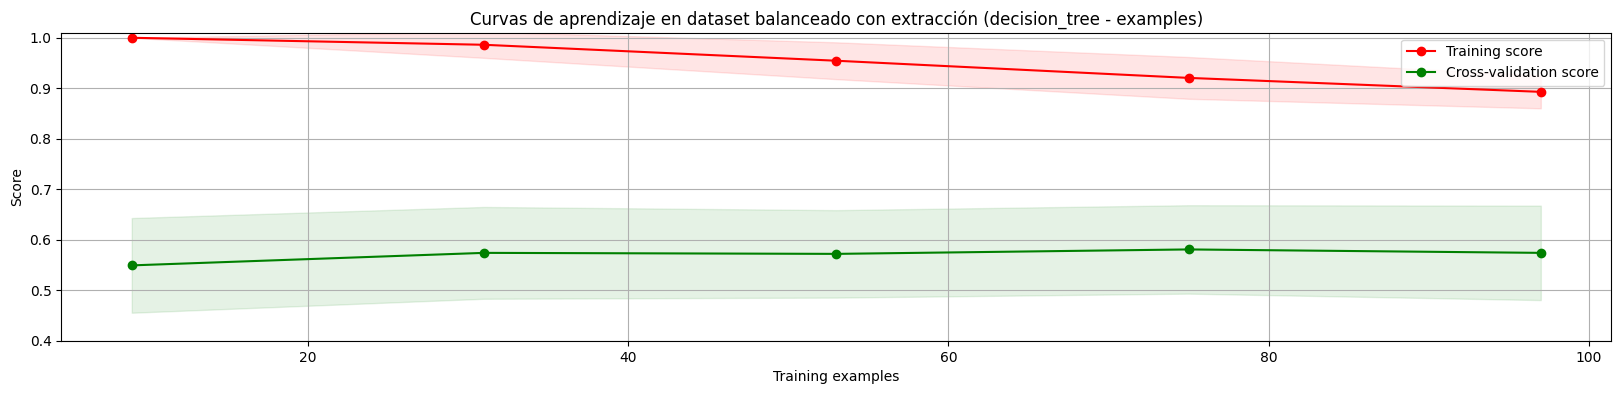

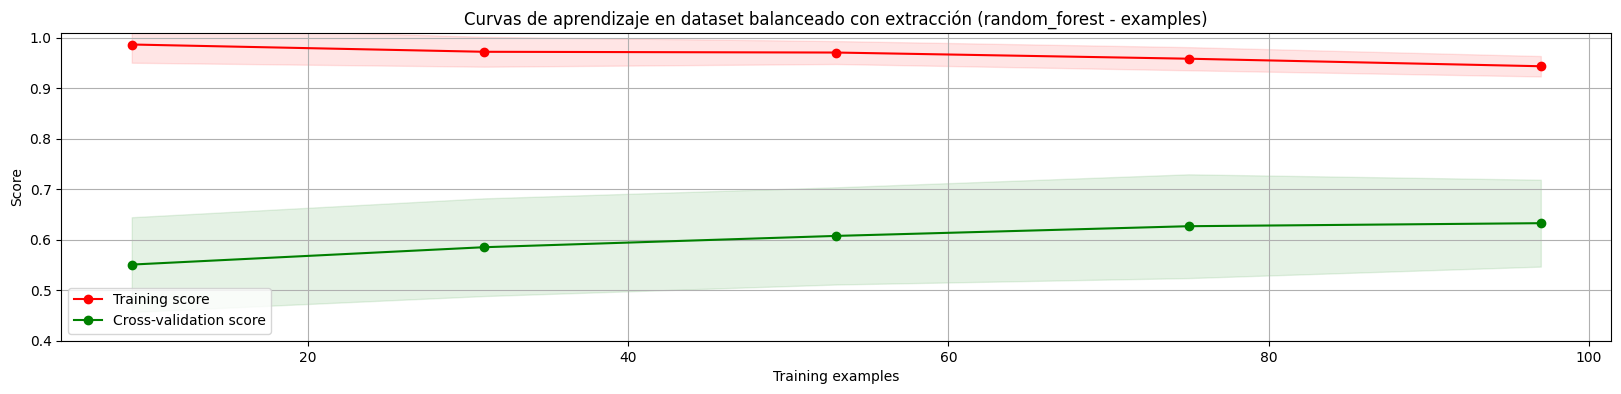

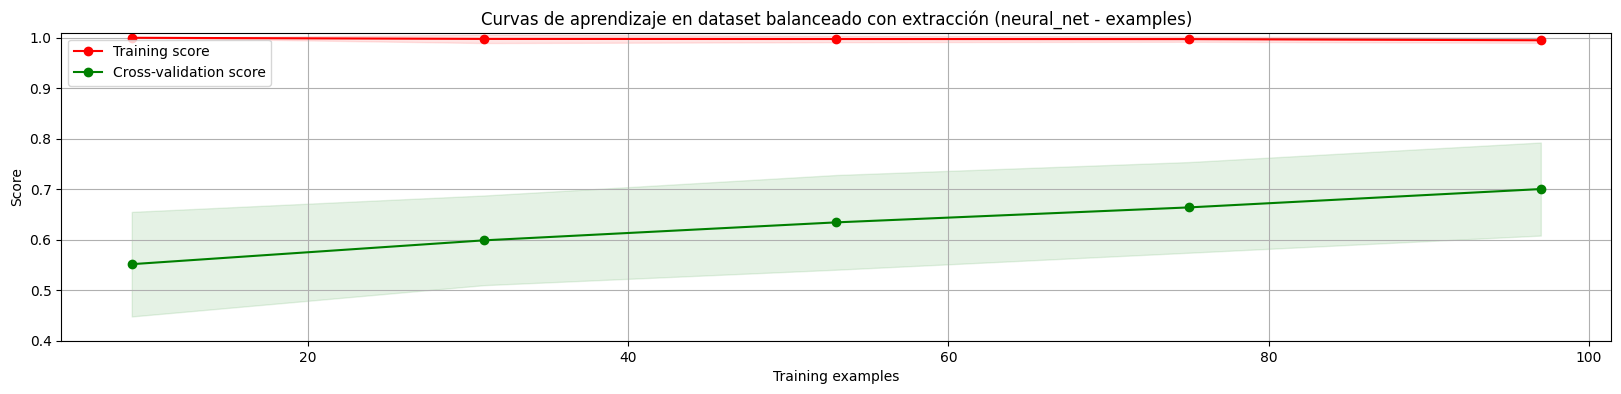

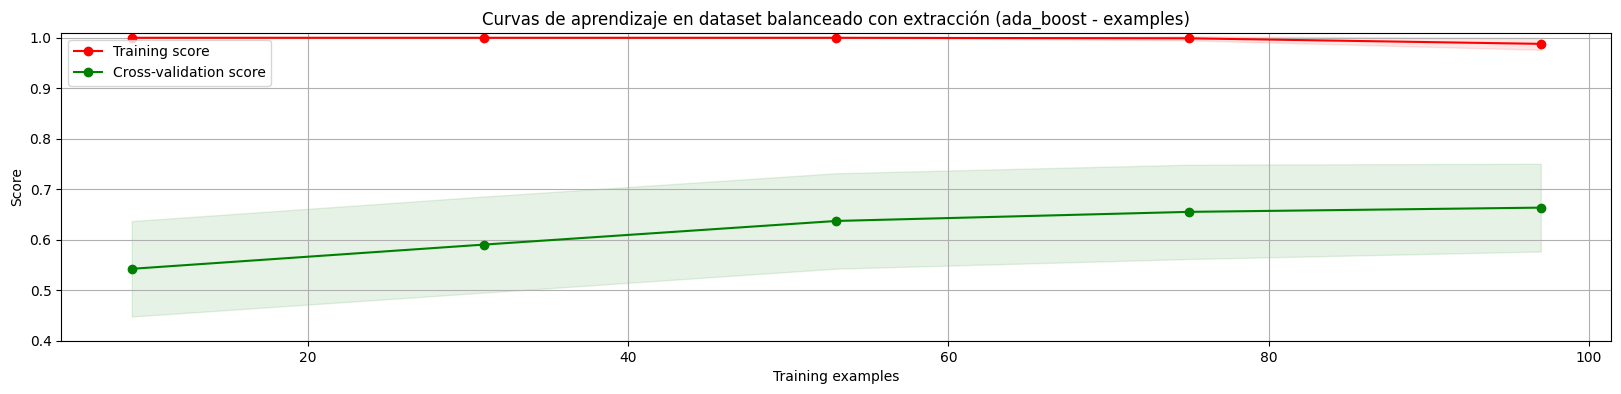

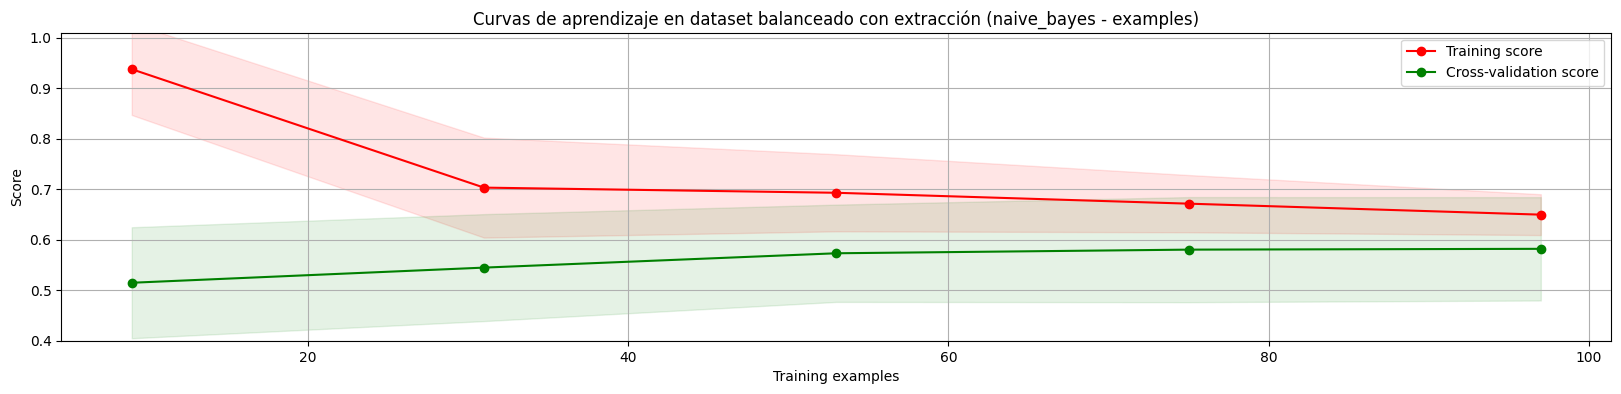

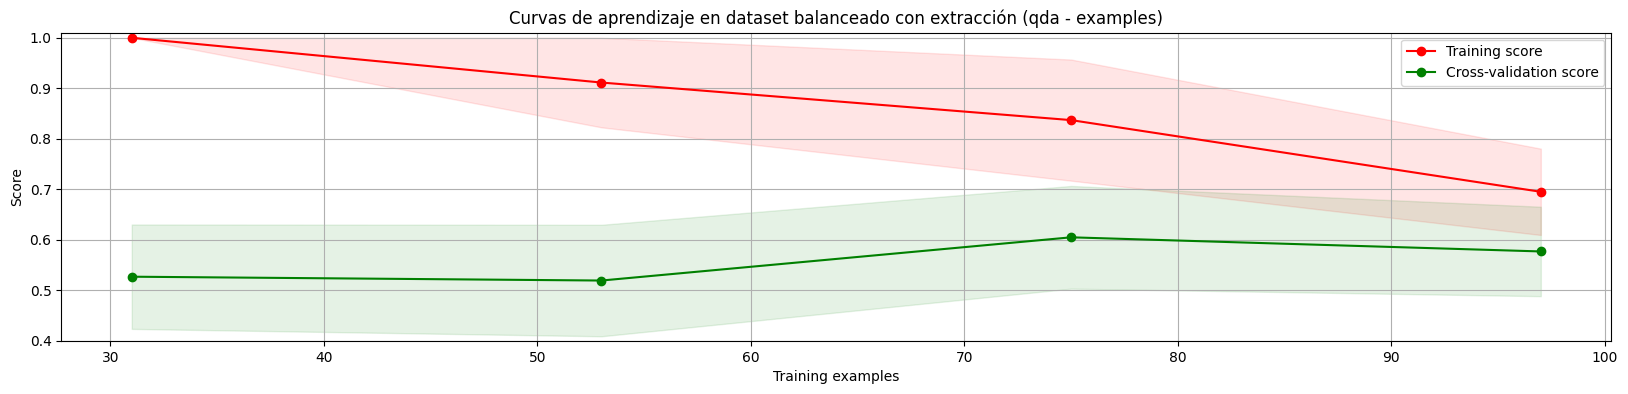

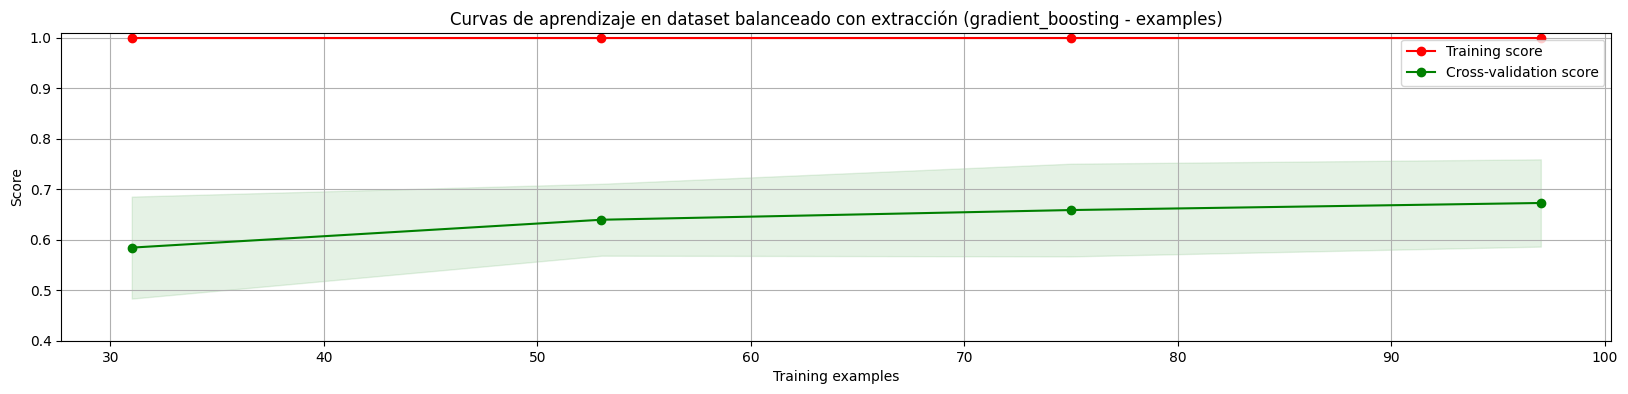

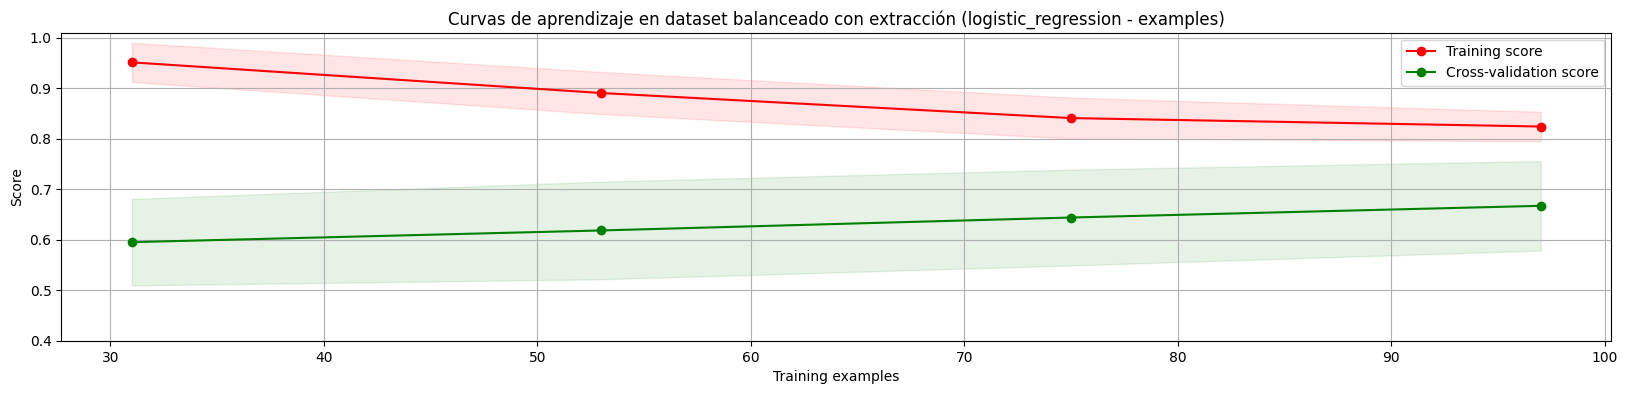

In [118]:
for classifier_name in classifiers:
    learning_curves_examples(
        file_path='../../resources/cleaned/ext_bal_cle_respuestas_form_1671774115.csv',
        classifier_name=classifier_name,
        dataset_name='balanceado con extracción'
    )

## COMPARACIÓN DE ALGORITMOS

### Comparación de métricas

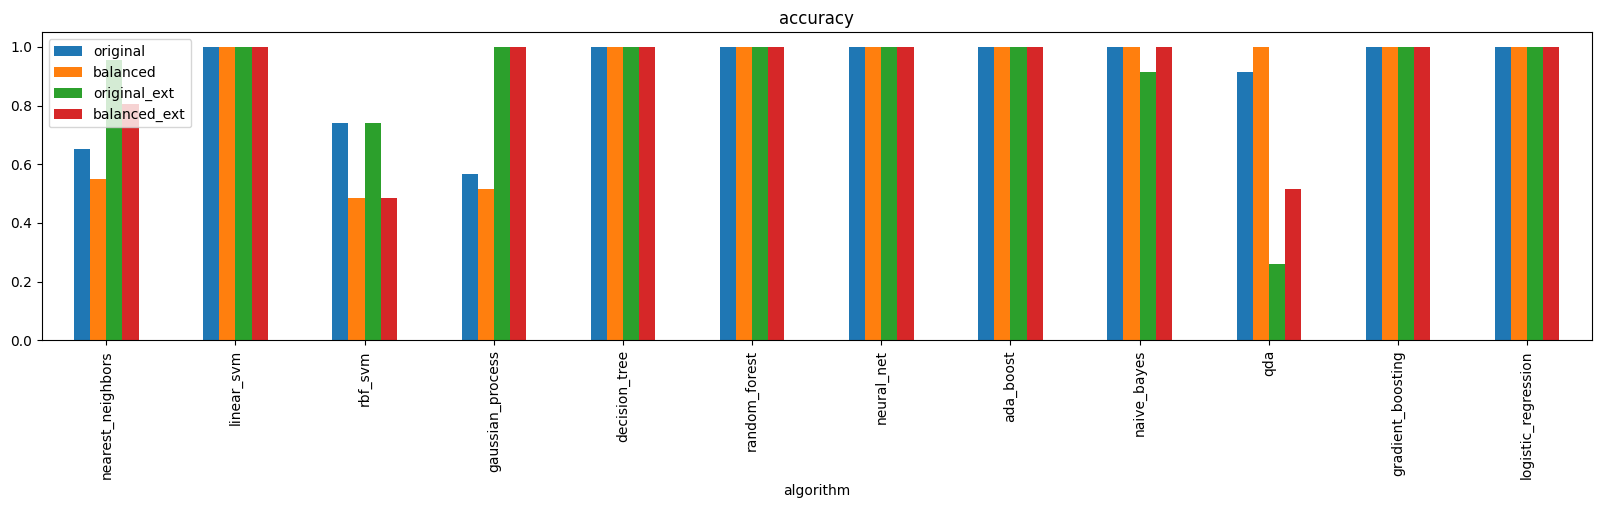

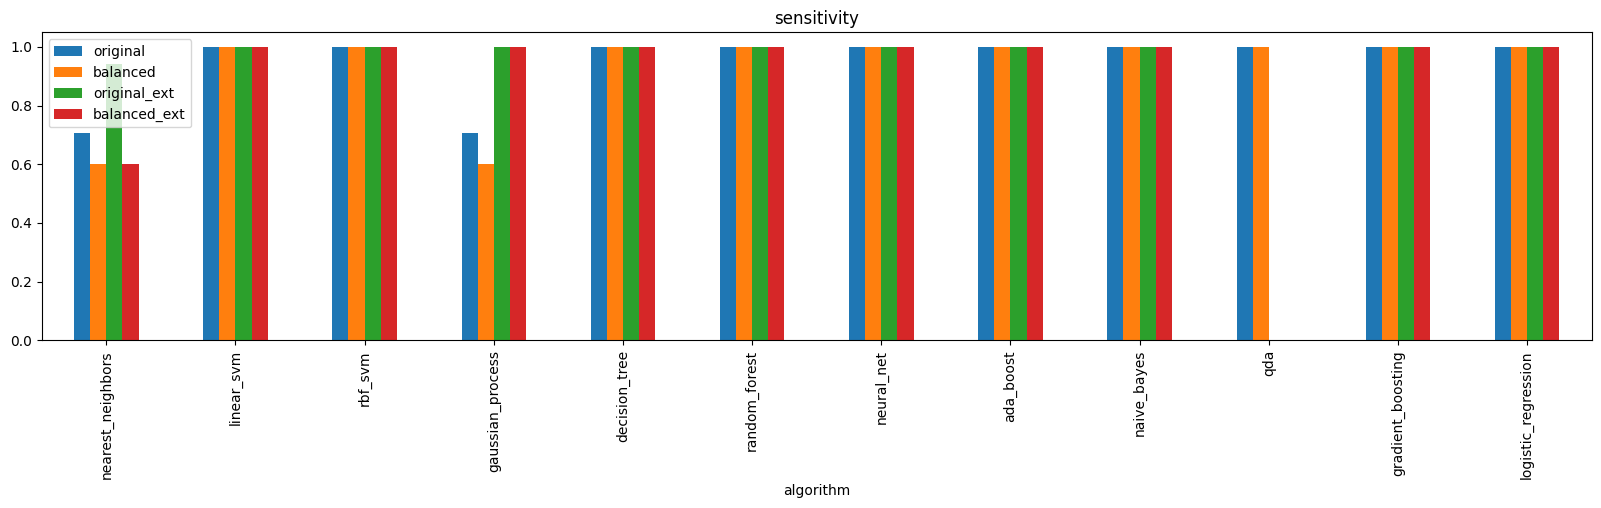

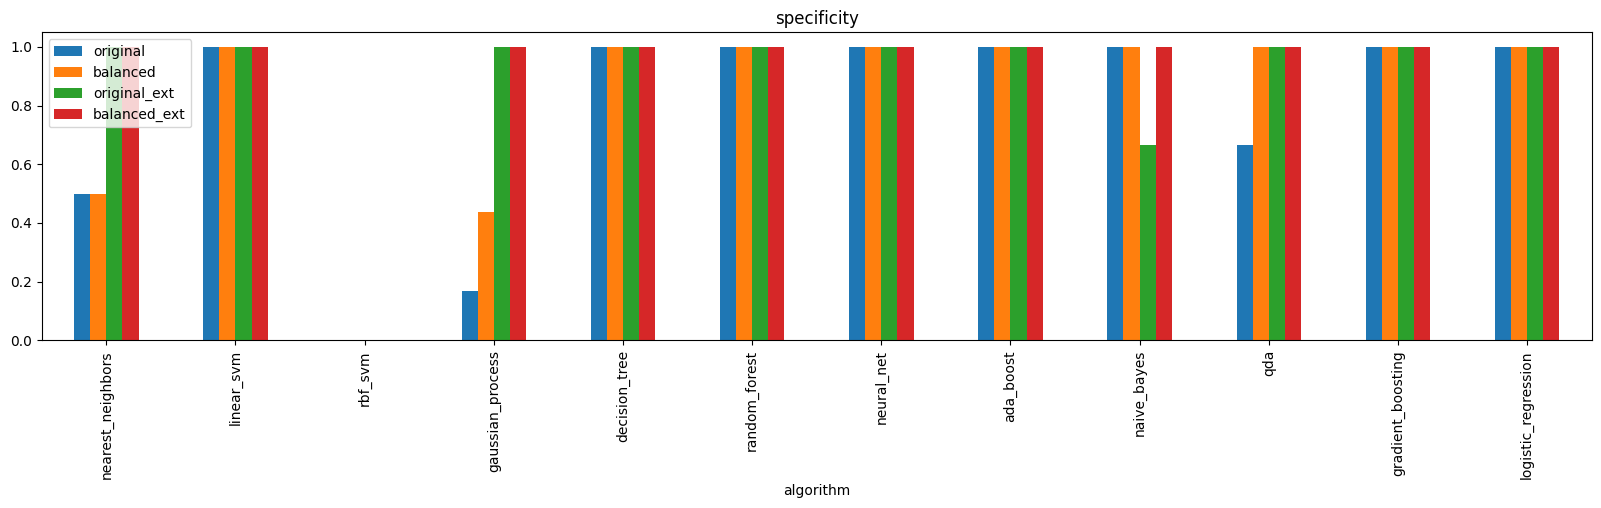

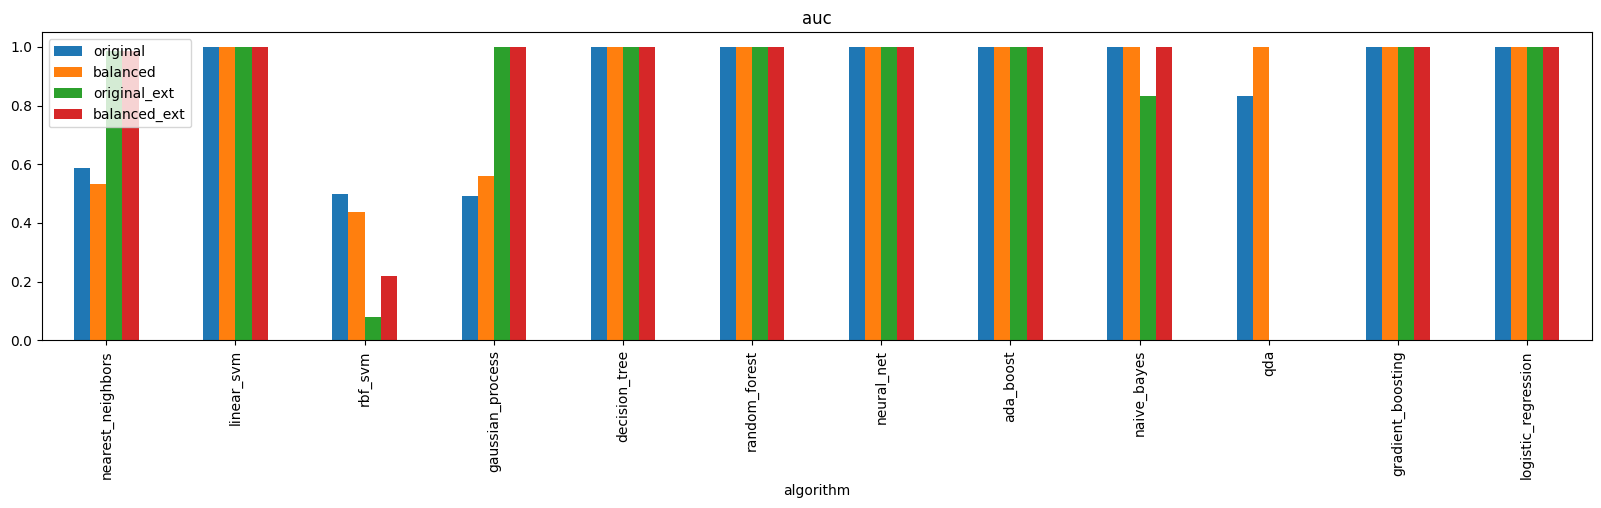

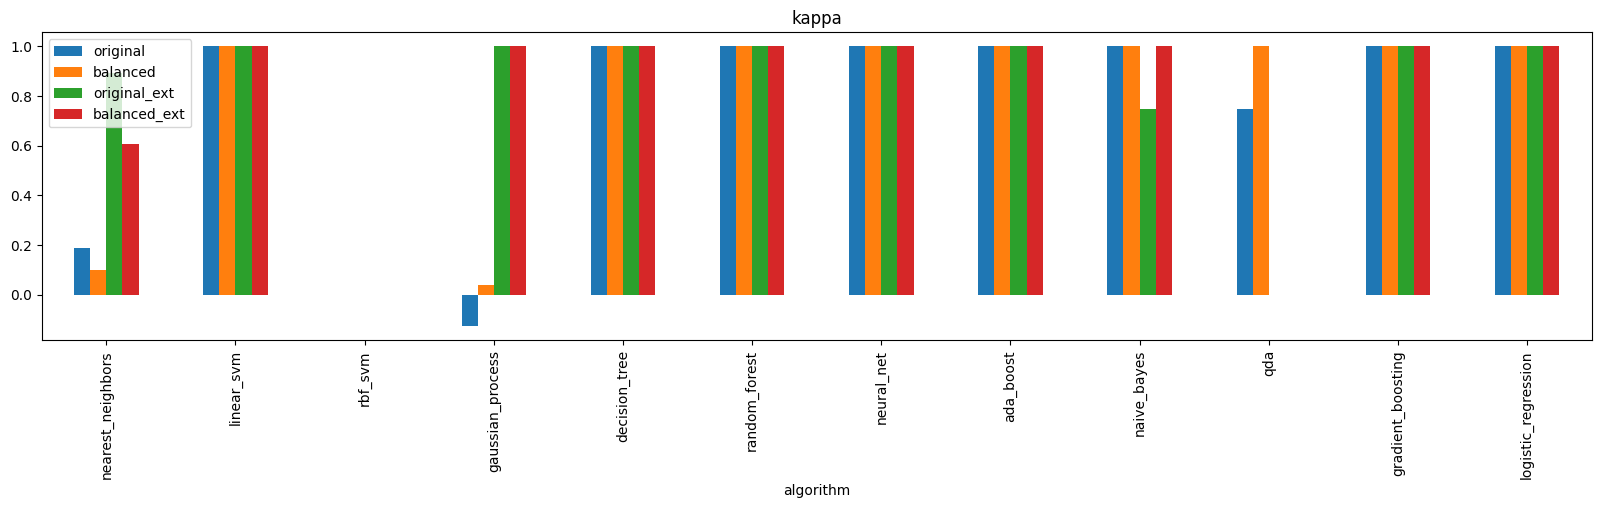

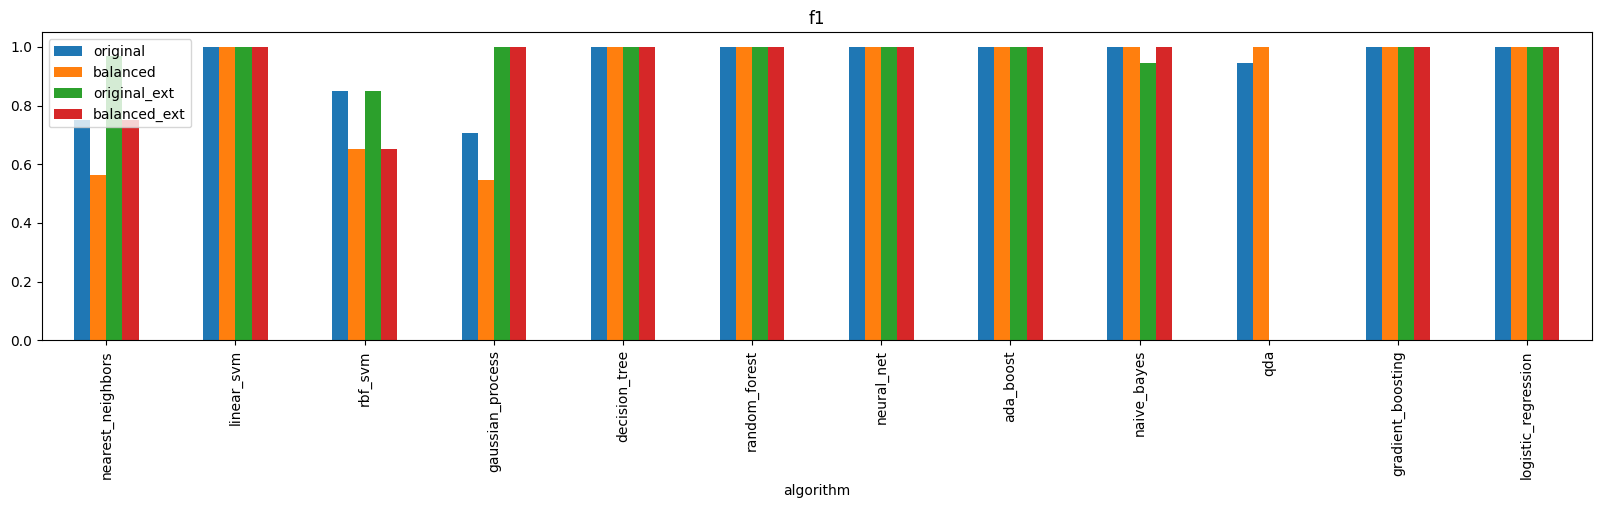

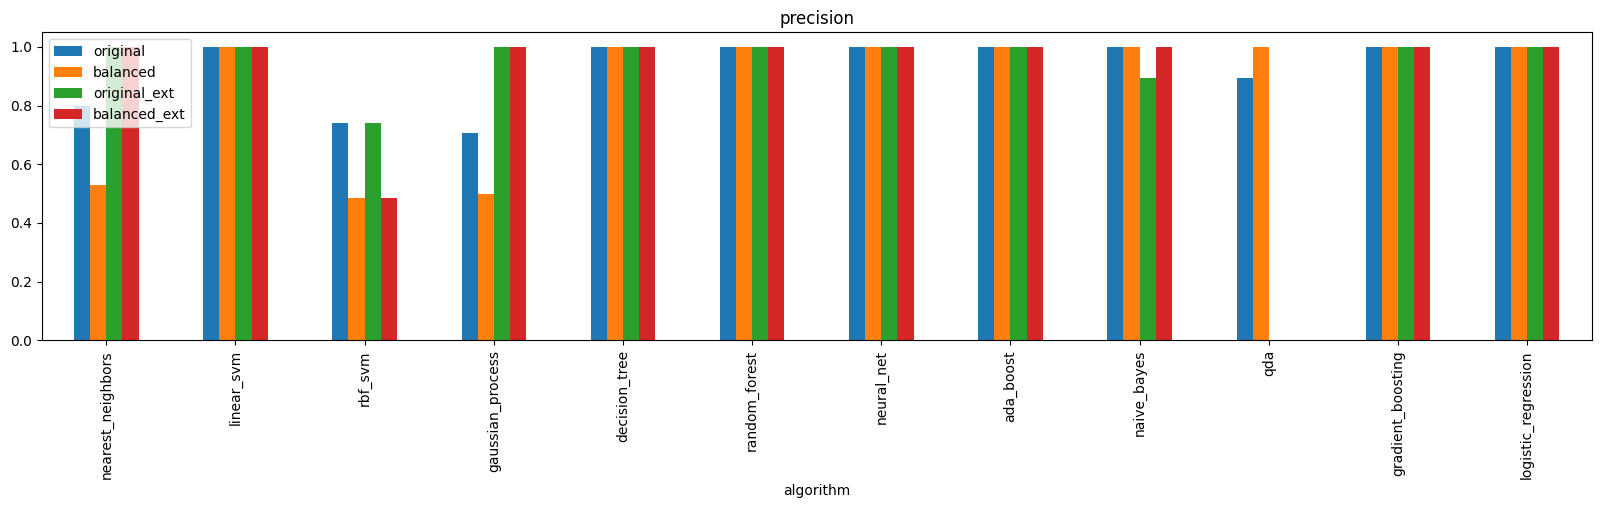

In [114]:

for metric in metrics:
    df = pd.DataFrame(
        data=[],
        columns=['algorithm', 'original', 'balanced',
                 'original_ext', 'balanced_ext']
    )

    df['algorithm'] = df_original['algorithm']
    df['original'] = df_original[metric]
    df['balanced'] = df_balanced[metric]
    df['original_ext'] = df_original_ext[metric]
    df['balanced_ext'] = df_balanced_ext[metric]

    df.plot.bar(
        x='algorithm',
        figsize=(20, 4),
        title=f'{metric}'
    )


### Comparación de conteos

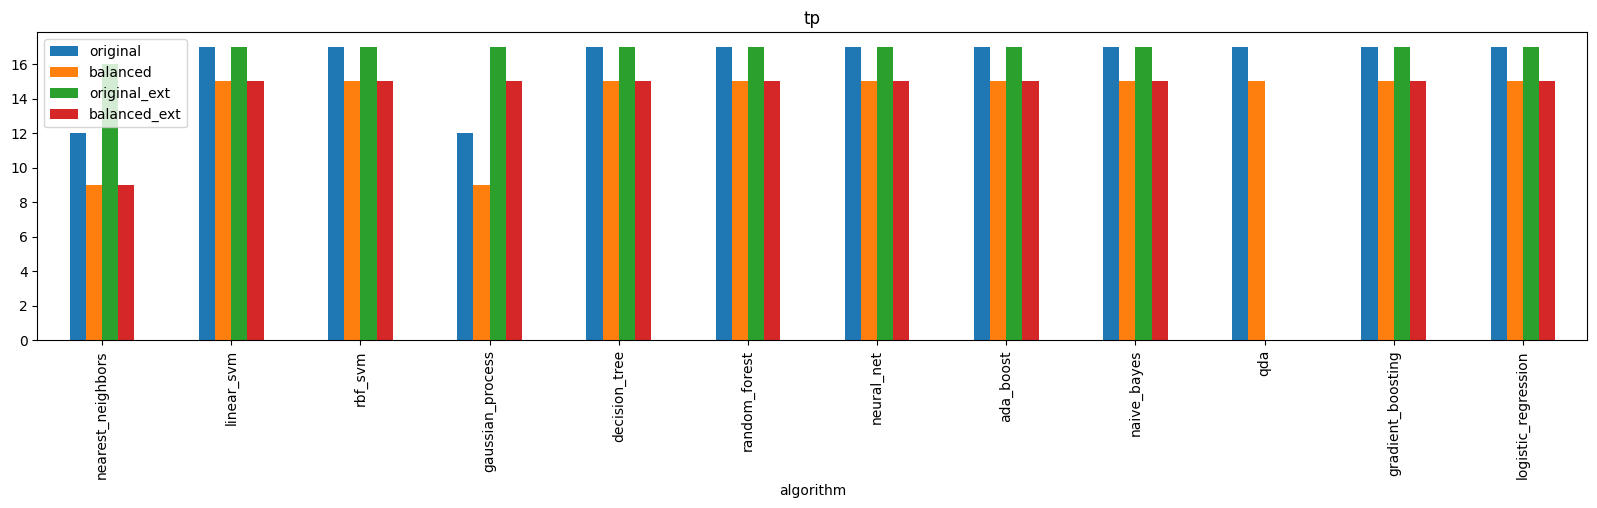

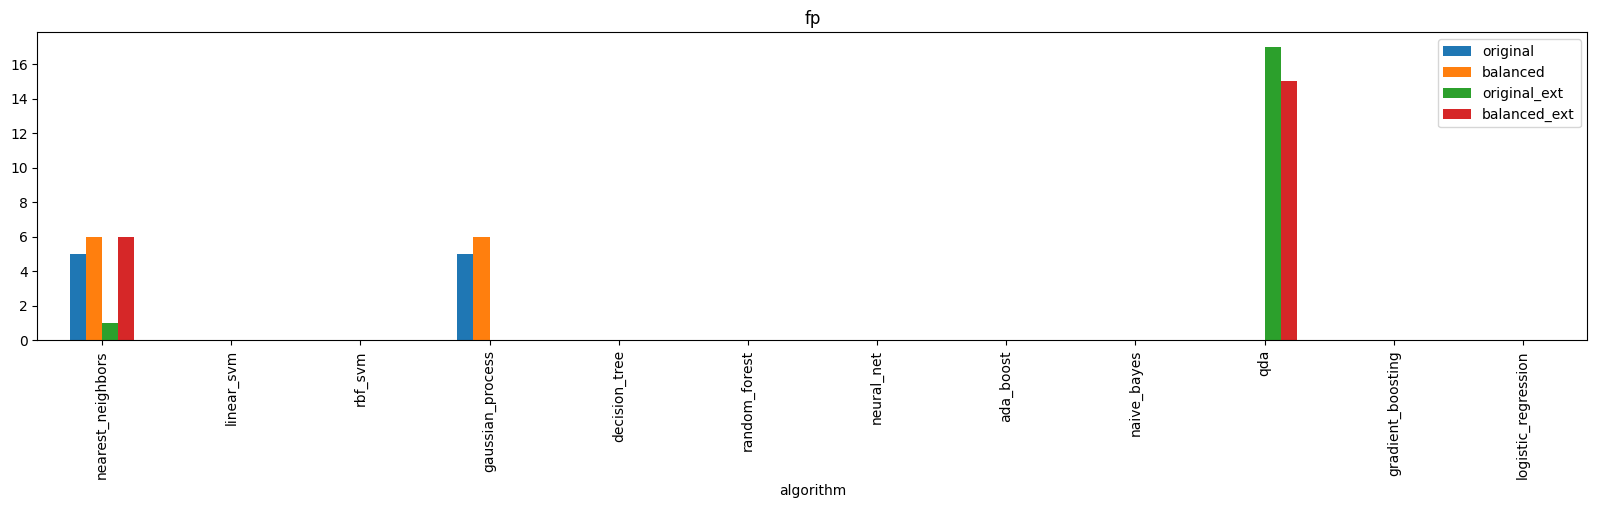

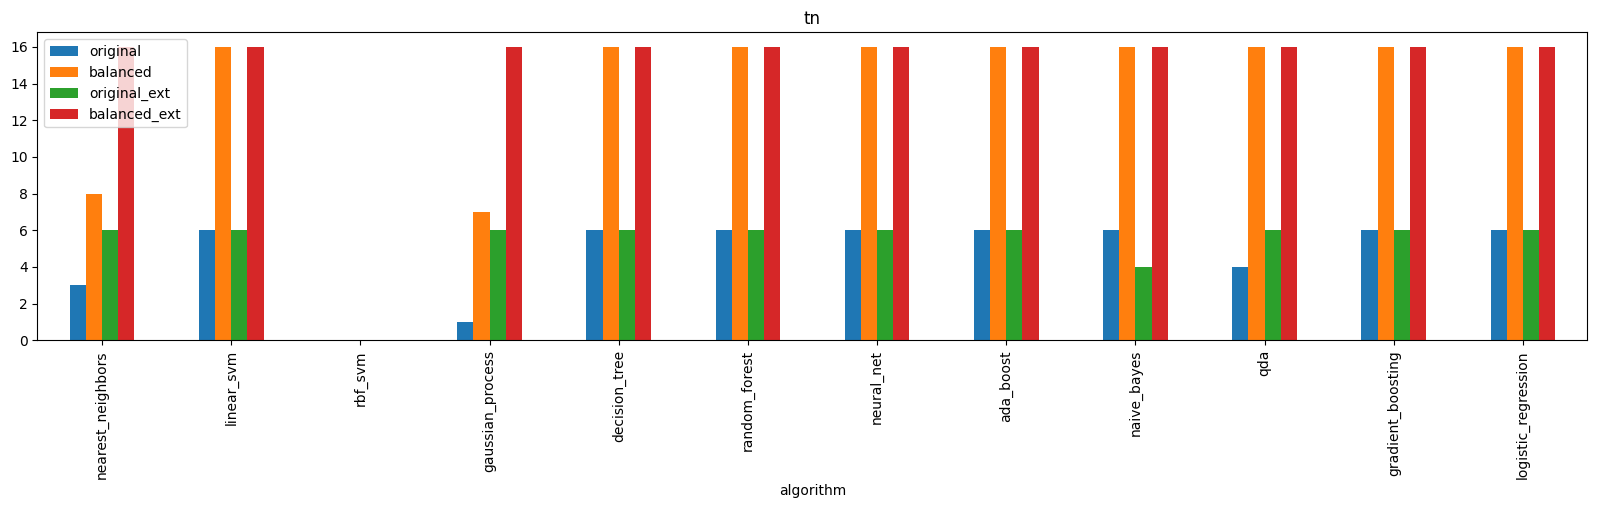

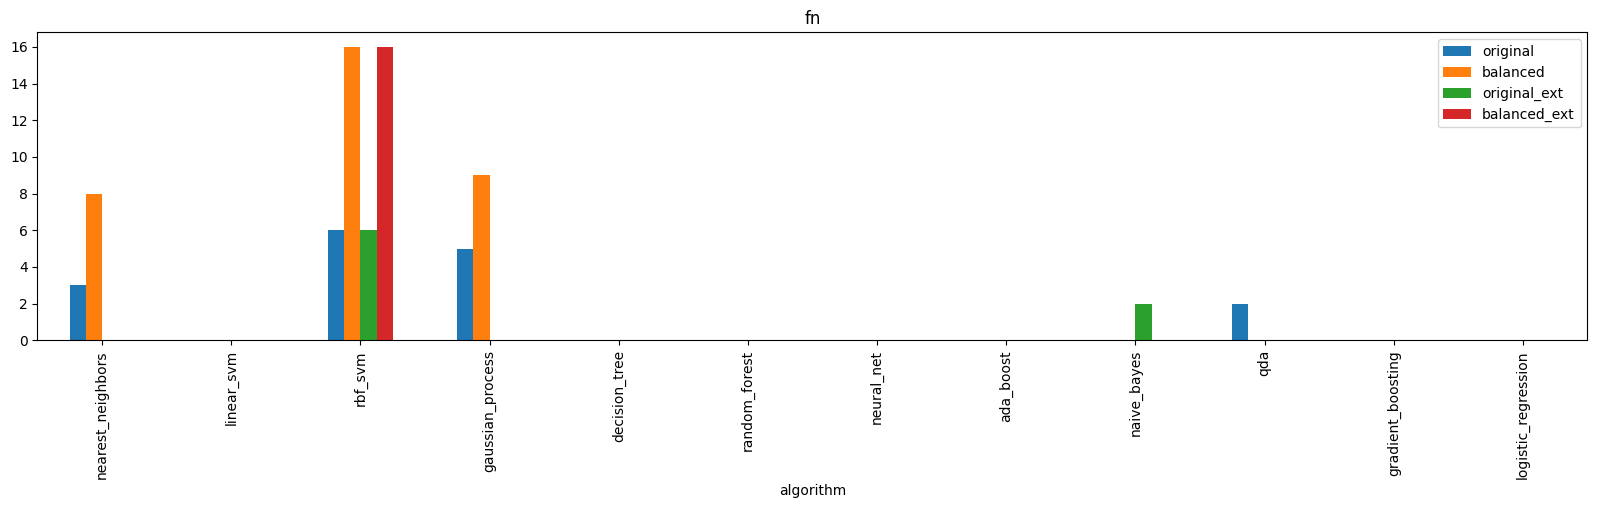

In [115]:
for count in counts:
    df = pd.DataFrame(
        data=[],
        columns=['algorithm', 'original', 'balanced',
                 'original_ext', 'balanced_ext']
    )

    df['algorithm'] = df_original['algorithm']
    df['original'] = df_original[count]
    df['balanced'] = df_balanced[count]
    df['original_ext'] = df_original_ext[count]
    df['balanced_ext'] = df_balanced_ext[count]

    df.plot.bar(
        x='algorithm',
        figsize=(20, 4),
        title=f'{count}'
    )